In [ ]:
# =======================================================================================
# CONFIGURATION ET IMPORTS
# =======================================================================================

# Installation des dépendances
!pip install -q scikit-learn>=1.0.0 torch>=1.9.0 torchvision hmmlearn seaborn plotly

# Montage Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports généraux
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import json
import random
import warnings
from typing import Dict, Any, List, Tuple, Callable, Union
from dataclasses import dataclass
warnings.filterwarnings('ignore')

# Configuration
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

# Vérification environnement
print(" CONFIGURATION ENVIRONNEMENT")
print("="*50)
print(f" Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f" Python: {sys.version.split()[0]}")
print(f" NumPy: {np.__version__}")
print(f" PyTorch: {torch.__version__}")

# Configuration paths
DATA_PATH = "/content/drive/MyDrive/Data"  
RESULTS_PATH = "/content/results"
os.makedirs(RESULTS_PATH, exist_ok=True)

# Paramètres globaux du projet
RANDOM_STATE = 42
TARGET_POINTS = 1024  # Points par nuage après sous-échantillonnage
N_CLASSES = 6  # Nombre de classes d'arbres

# Classes d'arbres
TREE_CLASSES = ['Buche', 'Eiche', 'Douglasie', 'Fichte', 'Kiefer', 'Roteiche']
CLASS_NAMES_FR = {
    'Buche': 'Hêtre',
    'Eiche': 'Chêne',
    'Douglasie': 'Sapin de Douglas',
    'Fichte': 'Épicéa',
    'Kiefer': 'Pin',
    'Roteiche': 'Chêne rouge'
}

# Vérification dataset
if os.path.exists(DATA_PATH):
    subdirs = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
    print(f"\n Dataset trouvé: {len(subdirs)} dossiers")
    for subdir in subdirs:
        if subdir in TREE_CLASSES:
            files_count = len([f for f in os.listdir(os.path.join(DATA_PATH, subdir))
                              if f.lower().endswith(('.txt', '.pts', '.xyz', '.ply'))])
            print(f"    {subdir}: {files_count} fichiers")
else:
    print(f"  Dataset non trouvé dans {DATA_PATH}")
    print("   Veuillez vérifier le chemin vers vos données")

# Initialisation random seeds
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

print("\n Configuration terminée")
print("="*50)

📊 CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES
🔄 Chargement du dataset...
📂 Buche (Hêtre): 164 fichiers
   ✅ 164/164 fichiers traités
📂 Eiche (Chêne): 22 fichiers
   ✅ 22/22 fichiers traités
📂 Douglasie (Sapin de Douglas): 184 fichiers
   ✅ 184/184 fichiers traités
📂 Fichte (Épicéa): 159 fichiers
   ✅ 159/159 fichiers traités
📂 Kiefer (Pin): 25 fichiers
   ✅ 25/25 fichiers traités
📂 Roteiche (Chêne rouge): 103 fichiers
   ✅ 103/103 fichiers traités

📊 Dataset initial: 657 échantillons, forme: (657, 1024, 3)

⚖️ Équilibrage des classes...
📊 Équilibrage des classes (objectif: 184 échantillons/classe)
   Classe 0: 164 → 184
   Classe 1: 184 → 184
   Classe 2: 22 → 184
   Classe 3: 159 → 184
   Classe 4: 25 → 184
   Classe 5: 103 → 184
✅ Dataset final: 1104 échantillons équilibrés

⏱️ Temps de chargement: 389.86s

📊 Division du dataset...
🔵 Train: 662 échantillons (60.0%)
🟡 Validation: 221 échantillons (20.0%)
🔴 Test: 221 échantillons (20.0%)

🔧 Extraction des caractéristiques pour MLP...
🔧 Ext

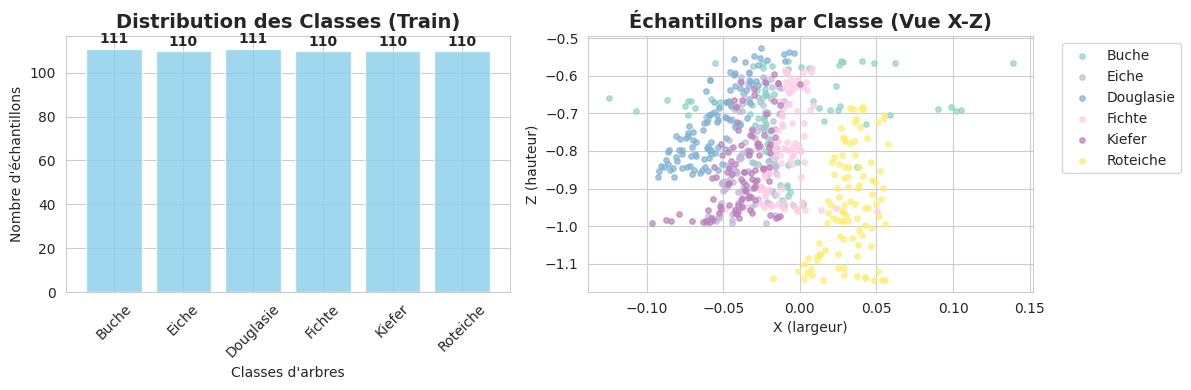


✅ DONNÉES CHARGÉES ET PRÉTRAITÉES AVEC SUCCÈS


In [ ]:
# =======================================================================================
#CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES
# =======================================================================================

print(" CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES")
print("="*60)

class PointCloudDataProcessor:
    """Processeur de données pour nuages de points 3D avec augmentation intégrée"""

    def __init__(self, data_path: str, target_points: int = 1024):
        self.data_path = data_path
        self.target_points = target_points
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.dataset_stats = {}

    def load_point_cloud_file(self, file_path: str) -> np.ndarray:
        """Charge un fichier de nuage de points avec gestion multi-format"""
        try:
            points = []
            encodings = ['utf-8', 'latin-1', 'cp1252']

            for encoding in encodings:
                try:
                    with open(file_path, 'r', encoding=encoding) as f:
                        for line_num, line in enumerate(f):
                            line = line.strip()

                            # Ignorer lignes vides et commentaires
                            if not line or line.startswith('#') or line.startswith('//'):
                                continue

                            # Gestion en-tête .pts
                            if line_num == 0 and file_path.endswith('.pts'):
                                try:
                                    int(line)
                                    continue
                                except ValueError:
                                    pass

                            # Parser coordonnées
                            try:
                                parts = line.replace(',', ' ').split()
                                if len(parts) >= 3:
                                    x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
                                    points.append([x, y, z])
                            except (ValueError, IndexError):
                                continue
                    break
                except UnicodeDecodeError:
                    continue

            points_array = np.array(points)

            # Validation et nettoyage
            if len(points_array) > 0:
                mask = np.isfinite(points_array).all(axis=1)
                points_array = points_array[mask]

                if len(points_array) < 10:  # Minimum viable
                    return np.array([])

            return points_array

        except Exception as e:
            print(f" Erreur {os.path.basename(file_path)}: {str(e)[:50]}...")
            return np.array([])

    def subsample_point_cloud(self, points: np.ndarray, target_n: int) -> np.ndarray:
        """Sous-échantillonnage stratifié préservant la structure 3D"""
        n_points = len(points)

        if n_points == 0:
            return np.zeros((target_n, 3))

        if n_points <= target_n:
            # Augmentation intelligente
            if n_points < target_n // 2:
                needed = target_n - n_points
                indices = np.random.choice(n_points, needed, replace=True)
                duplicated = points[indices] + np.random.normal(0, 0.01, (needed, 3))
                return np.vstack([points, duplicated])
            else:
                indices = np.random.choice(n_points, target_n, replace=True)
                return points[indices]
        else:
            # Sous-échantillonnage stratifié par hauteur (axe Z)
            z_min, z_max = points[:, 2].min(), points[:, 2].max()
            n_strata = 5
            samples_per_stratum = target_n // n_strata
            remaining = target_n % n_strata

            sampled_points = []

            for i in range(n_strata):
                z_start = z_min + i * (z_max - z_min) / n_strata
                z_end = z_min + (i + 1) * (z_max - z_min) / n_strata

                stratum_mask = (points[:, 2] >= z_start) & (points[:, 2] < z_end)
                stratum_points = points[stratum_mask]

                if len(stratum_points) > 0:
                    n_sample = samples_per_stratum + (1 if i < remaining else 0)
                    n_sample = min(n_sample, len(stratum_points))

                    if n_sample > 0:
                        indices = np.random.choice(len(stratum_points), n_sample, replace=False)
                        sampled_points.append(stratum_points[indices])

            if sampled_points:
                result = np.vstack(sampled_points)
                # Ajustement final si nécessaire
                if len(result) < target_n:
                    remaining_needed = target_n - len(result)
                    additional_indices = np.random.choice(len(points), remaining_needed, replace=False)
                    result = np.vstack([result, points[additional_indices]])
                elif len(result) > target_n:
                    indices = np.random.choice(len(result), target_n, replace=False)
                    result = result[indices]
                return result
            else:
                # Fallback
                indices = np.random.choice(n_points, target_n, replace=False)
                return points[indices]

    def normalize_point_cloud(self, points: np.ndarray) -> np.ndarray:
        """Normalisation centrée et mise à l'échelle"""
        if len(points) == 0:
            return points

        # Centrage sur origine
        centroid = np.mean(points, axis=0)
        points_centered = points - centroid

        # Normalisation par distance max
        distances = np.sqrt(np.sum(points_centered**2, axis=1))
        max_dist = np.max(distances)

        if max_dist > 1e-8:
            points_normalized = points_centered / max_dist
        else:
            points_normalized = points_centered

        return points_normalized

    def augment_point_cloud(self, points: np.ndarray, aug_type: str = 'realistic') -> np.ndarray:
        """Augmentation réaliste pour arbres"""
        augmented = points.copy()

        if aug_type == 'realistic':
            # Rotation azimutale (naturelle pour arbres)
            angle_z = np.random.uniform(-np.pi, np.pi)
            cos_z, sin_z = np.cos(angle_z), np.sin(angle_z)

            rotation_z = np.array([
                [cos_z, -sin_z, 0],
                [sin_z, cos_z, 0],
                [0, 0, 1]
            ])

            augmented = augmented @ rotation_z.T

            # Inclinaisons légères (vent, terrain)
            if np.random.random() > 0.5:
                angle_x = np.random.uniform(-0.1, 0.1)  # ±5.7°
                cos_x, sin_x = np.cos(angle_x), np.sin(angle_x)

                rotation_x = np.array([
                    [1, 0, 0],
                    [0, cos_x, -sin_x],
                    [0, sin_x, cos_x]
                ])

                augmented = augmented @ rotation_x.T

            # Mise à l'échelle différentielle (hauteur vs largeur)
            if np.random.random() > 0.3:
                scale_xy = np.random.uniform(0.9, 1.1)
                scale_z = np.random.uniform(0.8, 1.2)

                scale_matrix = np.diag([scale_xy, scale_xy, scale_z])
                augmented = augmented @ scale_matrix

            # Bruit léger
            if np.random.random() > 0.2:
                noise = np.random.normal(0, 0.005, augmented.shape)
                augmented += noise

        return augmented

    def balance_classes(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Équilibrage des classes par augmentation"""
        unique_classes, class_counts = np.unique(y, return_counts=True)
        max_samples = np.max(class_counts)

        print(f" Équilibrage des classes (objectif: {max_samples} échantillons/classe)")

        X_balanced = []
        y_balanced = []

        for class_idx in unique_classes:
            class_mask = y == class_idx
            class_samples = X[class_mask]
            current_count = len(class_samples)

            print(f"   Classe {class_idx}: {current_count} → {max_samples}")

            # Ajouter originaux
            X_balanced.extend(class_samples)
            y_balanced.extend([class_idx] * current_count)

            # Générer augmentations si nécessaire
            needed = max_samples - current_count
            if needed > 0:
                for i in range(needed):
                    source_idx = np.random.randint(0, current_count)
                    augmented = self.augment_point_cloud(class_samples[source_idx])
                    X_balanced.append(augmented)
                    y_balanced.append(class_idx)

        return np.array(X_balanced), np.array(y_balanced)

    def extract_handcrafted_features(self, X: np.ndarray) -> np.ndarray:
        """Extraction de caractéristiques artisanales enrichies"""
        print(" Extraction caractéristiques artisanales")

        features = []
        for point_cloud in X:
            cloud_features = []

            # === STATISTIQUES DE BASE ===
            # Moyennes et écarts-types par axe
            cloud_features.extend([
                np.mean(point_cloud[:, 0]), np.mean(point_cloud[:, 1]), np.mean(point_cloud[:, 2]),
                np.std(point_cloud[:, 0]), np.std(point_cloud[:, 1]), np.std(point_cloud[:, 2])
            ])

            # === PROPRIÉTÉS GÉOMÉTRIQUES ===
            mins = np.min(point_cloud, axis=0)
            maxs = np.max(point_cloud, axis=0)
            dimensions = maxs - mins
            cloud_features.extend(dimensions)  # Largeur, Profondeur, Hauteur

            volume = np.prod(dimensions + 1e-8)
            cloud_features.append(volume)

            # Centroïde et distances
            centroid = np.mean(point_cloud, axis=0)
            cloud_features.extend(centroid)

            distances = np.sqrt(np.sum((point_cloud - centroid)**2, axis=1))
            cloud_features.extend([
                np.mean(distances), np.std(distances),
                np.max(distances), np.min(distances), np.median(distances)
            ])

            # === CARACTÉRISTIQUES SPÉCIFIQUES ARBRES ===
            # Ratio hauteur/largeur
            height = dimensions[2]
            width = max(dimensions[0], dimensions[1])
            aspect_ratio = height / (width + 1e-8)
            cloud_features.append(aspect_ratio)

            # Densité verticale
            vertical_density = len(point_cloud) / (height + 1e-8)
            cloud_features.append(vertical_density)

            # Distribution verticale (skewness et kurtosis en Z)
            z_coords = point_cloud[:, 2]
            z_normalized = (z_coords - np.mean(z_coords)) / (np.std(z_coords) + 1e-8)
            skewness_z = np.mean(z_normalized**3)
            kurtosis_z = np.mean(z_normalized**4) - 3
            cloud_features.extend([skewness_z, kurtosis_z])

            # Compacité approximée
            try:
                from scipy.spatial import ConvexHull
                xy_points = point_cloud[:, :2]
                unique_xy = np.unique(xy_points, axis=0)
                if len(unique_xy) >= 3:
                    hull = ConvexHull(unique_xy)
                    surface_approx = hull.volume  # En 2D = aire
                    compactness = volume / (surface_approx + 1e-8)
                else:
                    compactness = 0
            except:
                compactness = 0
            cloud_features.append(compactness)

            features.append(cloud_features)

        features_array = np.array(features)
        print(f" {features_array.shape[1]} caractéristiques extraites")

        return features_array

    def load_dataset(self) -> Tuple[np.ndarray, np.ndarray]:
        """Charge le dataset complet avec preprocessing"""
        print(" Chargement du dataset...")

        all_point_clouds = []
        all_labels = []

        # Extensions supportées
        supported_extensions = ['.txt', '.pts', '.xyz', '.ply', '.pcd']

        for class_idx, tree_class in enumerate(TREE_CLASSES):
            class_path = os.path.join(self.data_path, tree_class)

            if not os.path.exists(class_path):
                print(f" Dossier manquant: {class_path}")
                continue

            # Trouver fichiers
            all_files = os.listdir(class_path)
            point_cloud_files = [f for f in all_files
                               if any(f.lower().endswith(ext) for ext in supported_extensions)]

            if not point_cloud_files:
                print(f" Pas de fichiers dans {class_path}")
                continue

            print(f" {tree_class} ({CLASS_NAMES_FR[tree_class]}): {len(point_cloud_files)} fichiers")

            # Charger et traiter
            class_point_clouds = []
            successful_loads = 0

            for file_name in point_cloud_files:
                file_path = os.path.join(class_path, file_name)
                points = self.load_point_cloud_file(file_path)

                if len(points) > 0:
                    # Pipeline complet de preprocessing
                    points_subsampled = self.subsample_point_cloud(points, self.target_points)
                    points_normalized = self.normalize_point_cloud(points_subsampled)

                    class_point_clouds.append(points_normalized)
                    all_labels.append(tree_class)
                    successful_loads += 1

            print(f"    {successful_loads}/{len(point_cloud_files)} fichiers traités")
            all_point_clouds.extend(class_point_clouds)

            # Statistiques
            if class_point_clouds:
                self.dataset_stats[tree_class] = {
                    'n_samples': len(class_point_clouds),
                    'class_index': class_idx,
                    'success_rate': successful_loads / len(point_cloud_files)
                }

        if not all_point_clouds:
            raise ValueError(" Aucun nuage de points valide chargé!")

        # Conversion et encodage
        X = np.array(all_point_clouds)
        y = self.label_encoder.fit_transform(all_labels)

        print(f"\n Dataset initial: {len(X)} échantillons, forme: {X.shape}")

        # Équilibrage automatique
        print("\n Équilibrage des classes...")
        X_balanced, y_balanced = self.balance_classes(X, y)

        print(f" Dataset final: {len(X_balanced)} échantillons équilibrés")

        return X_balanced, y_balanced

# =============================================================================
# EXÉCUTION DU CHARGEMENT
# =============================================================================

# Créeation du processeur de données
data_processor = PointCloudDataProcessor(
    data_path=DATA_PATH,
    target_points=TARGET_POINTS
)

# Charger le dataset complet
start_time = time.time()
X, y = data_processor.load_dataset()
loading_time = time.time() - start_time

print(f"\n⏱ Temps de chargement: {loading_time:.2f}s")

# Division stratifiée train/validation/test
print("\n Division du dataset...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f" Train: {len(X_train)} échantillons ({len(X_train)/len(X)*100:.1f}%)")
print(f" Validation: {len(X_val)} échantillons ({len(X_val)/len(X)*100:.1f}%)")
print(f" Test: {len(X_test)} échantillons ({len(X_test)/len(X)*100:.1f}%)")

# Extraction des caractéristiques artisanales
print("\n Extraction des caractéristiques pour MLP")
X_train_features = data_processor.extract_handcrafted_features(X_train)
X_val_features = data_processor.extract_handcrafted_features(X_val)
X_test_features = data_processor.extract_handcrafted_features(X_test)

print(f" Features: {X_train_features.shape[1]} dimensions")

# Visualisation rapide de la distribution
unique, counts = np.unique(y_train, return_counts=True)
class_names = [TREE_CLASSES[i] for i in unique]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
bars = plt.bar(class_names, counts, color='skyblue', alpha=0.8)
plt.title('Distribution des Classes (Train)', fontsize=14, fontweight='bold')
plt.xlabel('Classes d\'arbres')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
# Échantillons de chaque classe (vue 3D projetée)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique)))

for i, (class_idx, color) in enumerate(zip(unique, colors)):
    class_mask = y_train == class_idx
    class_samples_idx = np.where(class_mask)[0]
    if len(class_samples_idx) > 0:
        sample_idx = class_samples_idx[0]
        points = X_train[sample_idx]
        plt.scatter(points[:100, 0], points[:100, 2],
                   c=[color], alpha=0.7, s=15, label=class_names[i])

plt.title('Échantillons par Classe (Vue X-Z)', fontsize=14, fontweight='bold')
plt.xlabel('X (largeur)')
plt.ylabel('Z (hauteur)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("\n DONNÉES CHARGÉES ET PRÉTRAITÉES AVEC SUCCÈS")
print("="*60)

 MODÈLES DE CLASSIFICATION ET ÉVALUATION BASELINE
 ENTRAÎNEMENT DES MODÈLES BASELINE

 MLP BASELINE
------------------------------
 Entraînement MLP...
    Architecture: (256, 128, 64)
    Activation: relu
    Learning rate: 0.001
    Score validation: 0.1629
    Temps: 0.34s
    Itérations: 27

 ÉVALUATION MLP BASELINE
 Accuracy: 0.1674 (16.74%)

 Rapport de classification:
              precision    recall  f1-score   support

       Buche     0.0000    0.0000    0.0000        36
       Eiche     0.0000    0.0000    0.0000        37
   Douglasie     0.1674    1.0000    0.2868        37
      Fichte     0.0000    0.0000    0.0000        37
      Kiefer     0.0000    0.0000    0.0000        37
    Roteiche     0.0000    0.0000    0.0000        37

    accuracy                         0.1674       221
   macro avg     0.0279    0.1667    0.0478       221
weighted avg     0.0280    0.1674    0.0480       221



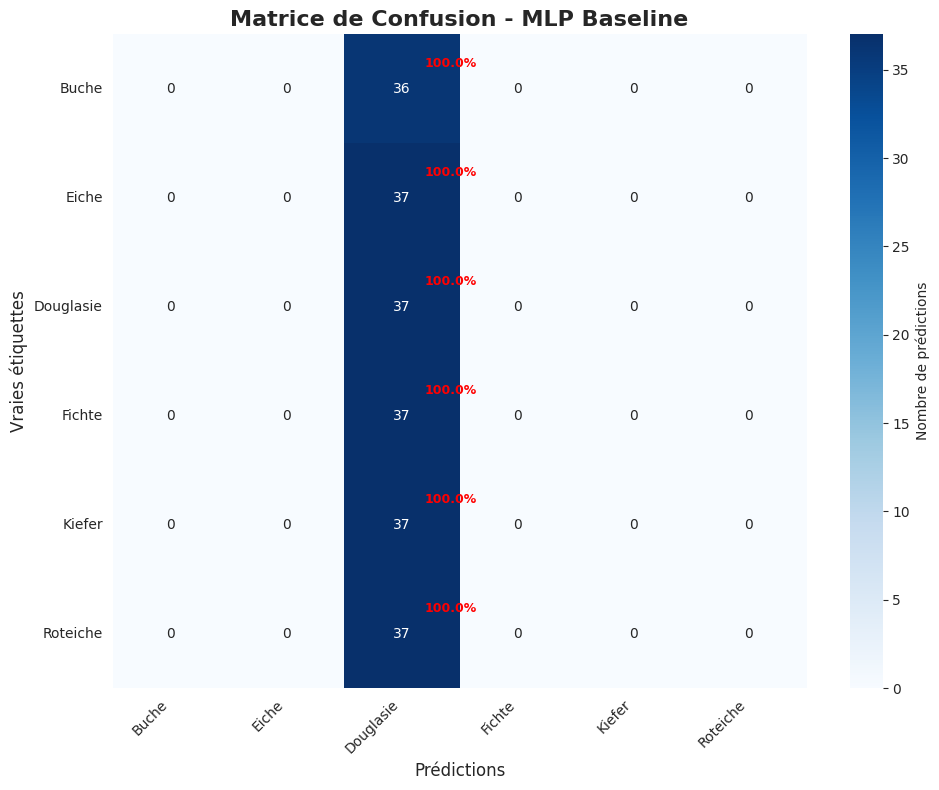

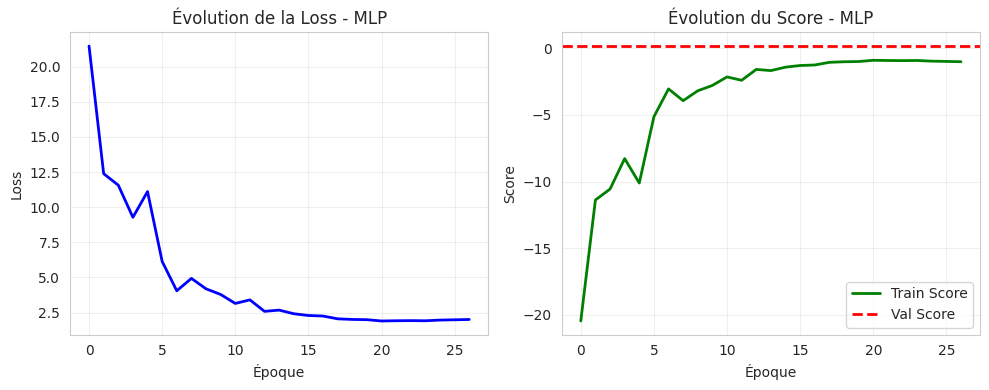


 DGCNN BASELINE
------------------------------
 Entraînement DGCNN...
    Architecture: k=15, dropout=0.4
    Batch size: 8, epochs: 25
    Device: cuda
   Époque   0: Train 38.82%, Val 46.61%
   Époque   5: Train 72.51%, Val 53.39%
   Époque  10: Train 79.46%, Val 66.97%
   Époque  15: Train 82.93%, Val 70.14%
   Époque  20: Train 91.69%, Val 71.49%
   Époque  24: Train 94.11%, Val 73.76%
    Meilleure accuracy: 80.54%
    Temps: 243.18s

 ÉVALUATION DGCNN BASELINE
 Accuracy: 0.7919 (79.19%)

 Rapport de classification:
              precision    recall  f1-score   support

       Buche     0.7879    0.7222    0.7536        36
       Eiche     0.6739    0.8378    0.7470        37
   Douglasie     0.8889    0.8649    0.8767        37
      Fichte     0.7667    0.6216    0.6866        37
      Kiefer     0.9167    0.8919    0.9041        37
    Roteiche     0.7500    0.8108    0.7792        37

    accuracy                         0.7919       221
   macro avg     0.7973    0.7915    0

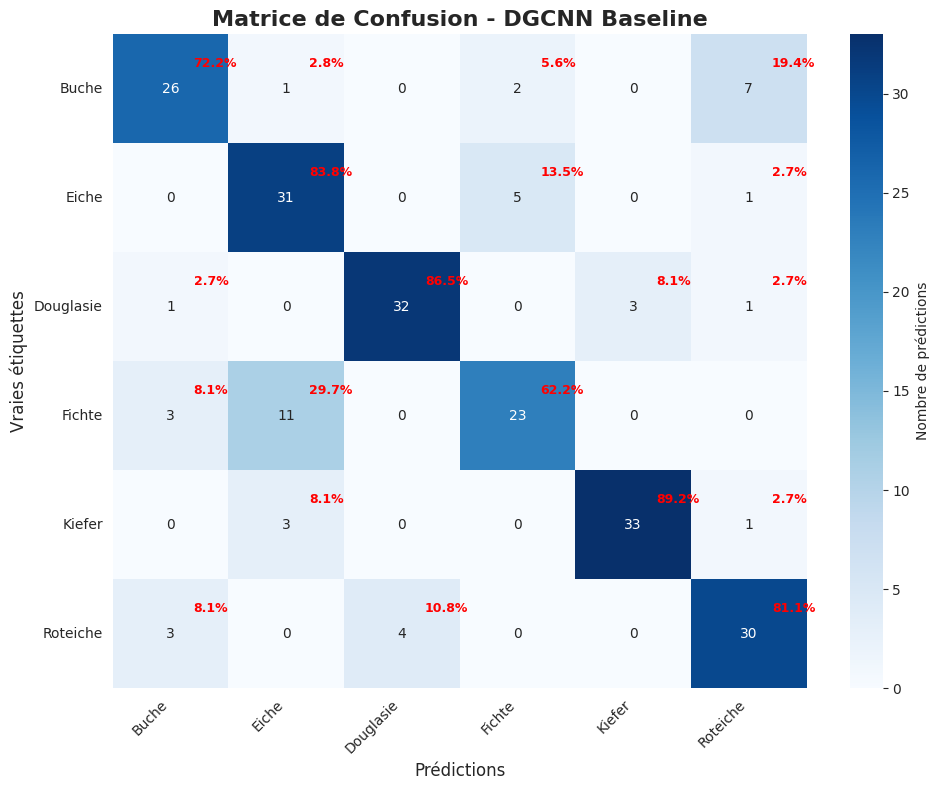

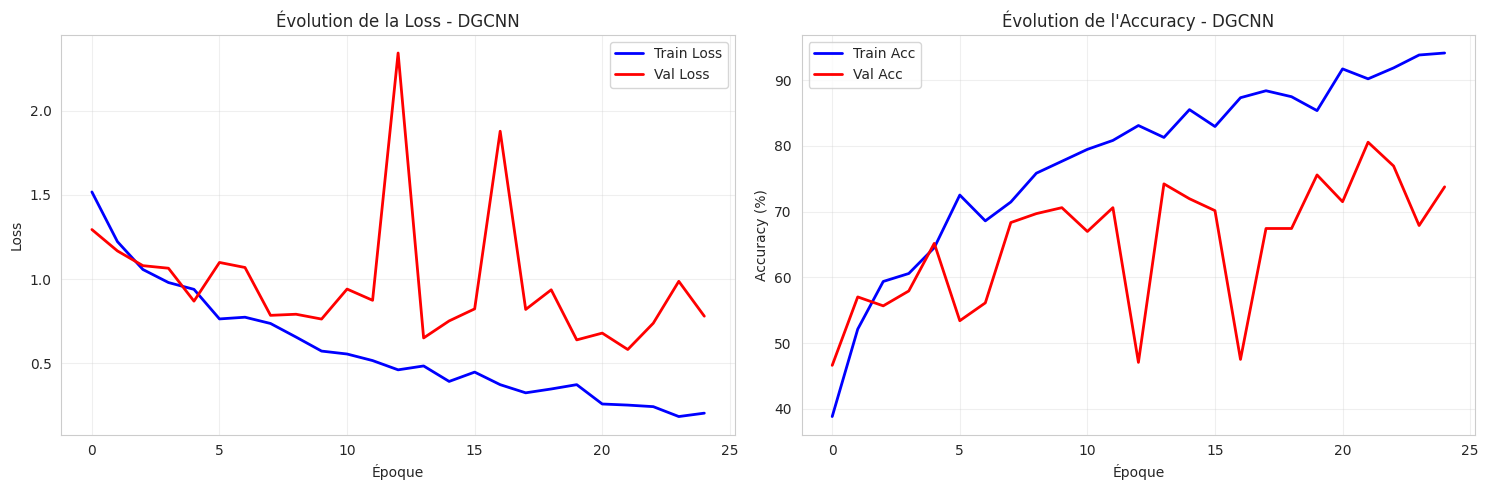


 RÉSUMÉ DES PERFORMANCES BASELINE
        Modèle Accuracy Accuracy (%) Temps (s)
  MLP Baseline   0.1674       16.74%      0.34
DGCNN Baseline   0.7919       79.19%    243.18


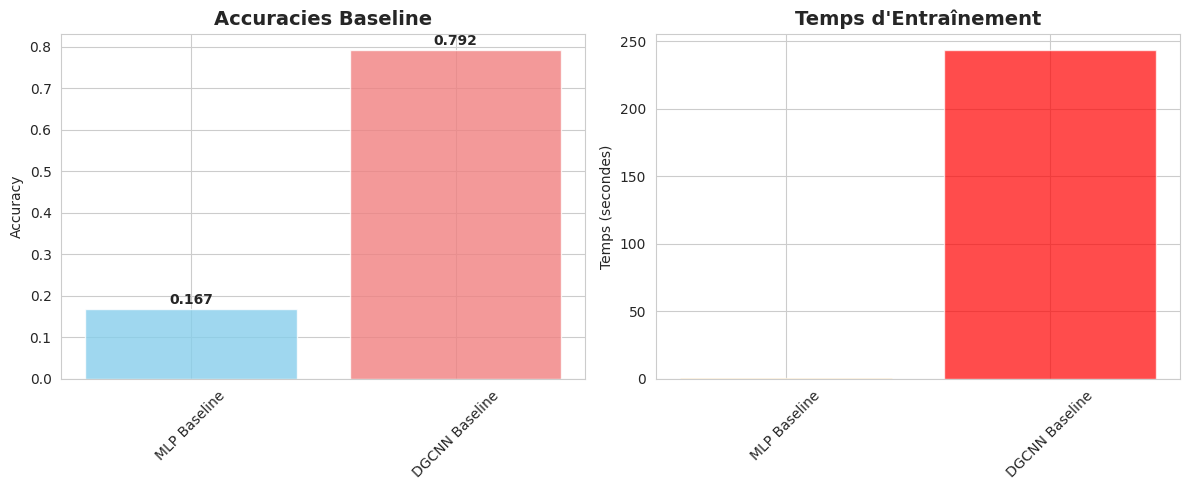


 Résultats baseline sauvegardés dans /content/results/baseline_results.json

 MODÈLES BASELINE ENTRAÎNÉS ET ÉVALUÉS


In [ ]:
# =======================================================================================
# MODÈLES DE CLASSIFICATION ET PERFORMANCES BASELINE
# =======================================================================================

print(" MODÈLES DE CLASSIFICATION ET ÉVALUATION BASELINE")
print("="*70)

# =============================================================================
# DATASET PYTORCH
# =============================================================================

class PointCloudDataset(Dataset):
    """Dataset PyTorch pour nuages de points 3D"""

    def __init__(self, point_clouds: np.ndarray, labels: np.ndarray, transform=None):
        self.point_clouds = torch.FloatTensor(point_clouds)
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        point_cloud = self.point_clouds[idx]
        label = self.labels[idx]

        if self.transform:
            point_cloud = self.transform(point_cloud)

        return point_cloud, label

# =============================================================================
# MODÈLE MLP OPTIMISÉ
# =============================================================================

class PointCloudMLP:
    """Réseau de Neurones Multi-Couches pour classification de nuages de points"""

    def __init__(self,
                 hidden_layer_sizes: Tuple = (256, 128, 64),
                 activation: str = 'relu',
                 learning_rate: float = 0.001,
                 max_iter: int = 300,
                 random_state: int = 42):

        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state

        self.model = None
        self.is_fitted = False
        self.training_history = {'loss': [], 'val_score': None}

    def create_model(self, n_features: int, n_classes: int):
        """Crée le modèle sklearn MLP avec configuration optimale"""
        self.model = MLPClassifier(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            learning_rate_init=self.learning_rate,
            max_iter=self.max_iter,
            random_state=self.random_state,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=20,
            alpha=0.0001,
            solver='adam',
            batch_size='auto',
            verbose=False
        )

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray = None, y_val: np.ndarray = None):
        """Entraîne le modèle avec monitoring"""
        if self.model is None:
            n_features = X_train.shape[1]
            n_classes = len(np.unique(y_train))
            self.create_model(n_features, n_classes)

        print(f" Entraînement MLP...")
        print(f"    Architecture: {self.hidden_layer_sizes}")
        print(f"    Activation: {self.activation}")
        print(f"    Learning rate: {self.learning_rate}")

        start_time = time.time()
        self.model.fit(X_train, y_train)
        training_time = time.time() - start_time

        self.is_fitted = True

        # Historique d'entraînement
        if hasattr(self.model, 'loss_curve_'):
            self.training_history['loss'] = self.model.loss_curve_

        # Évaluation validation
        if X_val is not None and y_val is not None:
            val_score = self.model.score(X_val, y_val)
            self.training_history['val_score'] = val_score
            print(f"    Score validation: {val_score:.4f}")

        print(f"    Temps: {training_time:.2f}s")
        print(f"    Itérations: {self.model.n_iter_}")

        return training_time

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not self.is_fitted:
            raise ValueError("Le modèle doit être entraîné avant prédiction")
        return self.model.predict(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if not self.is_fitted:
            raise ValueError("Le modèle doit être entraîné avant prédiction")
        return self.model.predict_proba(X)

    def get_params(self) -> Dict[str, Any]:
        return {
            'hidden_layer_sizes': self.hidden_layer_sizes,
            'activation': self.activation,
            'learning_rate': self.learning_rate,
            'max_iter': self.max_iter
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        self.model = None
        self.is_fitted = False

    def plot_training_history(self):
        """Affiche l'historique d'entraînement"""
        if self.training_history['loss']:
            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.plot(self.training_history['loss'], 'b-', linewidth=2)
            plt.title('Évolution de la Loss - MLP')
            plt.xlabel('Époque')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            train_scores = [1 - loss for loss in self.training_history['loss']]
            plt.plot(train_scores, 'g-', linewidth=2, label='Train Score')
            if self.training_history['val_score']:
                plt.axhline(y=self.training_history['val_score'],
                           color='r', linestyle='--', linewidth=2, label='Val Score')
            plt.title('Évolution du Score - MLP')
            plt.xlabel('Époque')
            plt.ylabel('Score')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

# =============================================================================
# DGCNN architecture
# =============================================================================

def knn_graph(x: torch.Tensor, k: int) -> torch.Tensor:
    """Construction du graphe k-NN avec gestion mémoire"""
    batch_size, num_dims, num_points = x.size()

    # Calcul efficace des distances
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    # k plus proches voisins
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

def get_graph_feature(x: torch.Tensor, k: int = 20, idx: torch.Tensor = None) -> torch.Tensor:
    """Construction des features de graphe pour DGCNN"""
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)

    if idx is None:
        idx = knn_graph(x, k=k)

    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)

    _, num_dims, _ = x.size()
    x = x.transpose(2, 1).contiguous()
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

class DGCNN(nn.Module):
    """Dynamic Graph CNN pour classification de nuages de points 3D"""

    def __init__(self, k: int = 20, num_classes: int = 6, dropout_rate: float = 0.5):
        super(DGCNN, self).__init__()
        self.k = k
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate

        # Edge Convolution Layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            self.bn1,
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, bias=False),  # 64*2 = 128 input
            self.bn2,
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, bias=False),  # 64*2 = 128 input
            self.bn3,
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, bias=False),  # 128*2 = 256 input
            self.bn4,
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Aggregation
        self.bn5 = nn.BatchNorm1d(1024)
        self.conv5 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),  # 64+64+128+256 = 512
            self.bn5,
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Classifier
        self.linear1 = nn.Linear(2048, 512, bias=False)  # 1024*2 = 2048
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=self.dropout_rate)

        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=self.dropout_rate)

        self.linear3 = nn.Linear(256, self.num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)

        # EdgeConv layers
        x1 = get_graph_feature(x, k=self.k)  # (B, 6, N, k)
        x1 = self.conv1(x1)  # (B, 64, N, k)
        x1 = x1.max(dim=-1, keepdim=False)[0]  # (B, 64, N)

        x2 = get_graph_feature(x1, k=self.k)  # (B, 128, N, k)
        x2 = self.conv2(x2)  # (B, 64, N, k)
        x2 = x2.max(dim=-1, keepdim=False)[0]  # (B, 64, N)

        x3 = get_graph_feature(x2, k=self.k)  # (B, 128, N, k)
        x3 = self.conv3(x3)  # (B, 128, N, k)
        x3 = x3.max(dim=-1, keepdim=False)[0]  # (B, 128, N)

        x4 = get_graph_feature(x3, k=self.k)  # (B, 256, N, k)
        x4 = self.conv4(x4)  # (B, 256, N, k)
        x4 = x4.max(dim=-1, keepdim=False)[0]  # (B, 256, N)

        # Feature aggregation
        x = torch.cat((x1, x2, x3, x4), dim=1)  # (B, 512, N)
        x = self.conv5(x)  # (B, 1024, N)

        # Global pooling
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)  # (B, 1024)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)  # (B, 1024)
        x = torch.cat((x1, x2), 1)  # (B, 2048)

        # Classification
        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)

        return x

class DGCNNTrainer:
    """Entraîneur DGCNN optimisé pour Colab"""

    def __init__(self,
                 k: int = 20,
                 num_classes: int = 6,
                 dropout_rate: float = 0.5,
                 learning_rate: float = 0.001,
                 batch_size: int = 16,
                 num_epochs: int = 50,
                 device: str = 'auto'):

        self.k = k
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs

        # Device
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        # Modèle
        self.model = DGCNN(
            k=self.k,
            num_classes=self.num_classes,
            dropout_rate=self.dropout_rate
        ).to(self.device)

        # Optimisation
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.7)

        # Historique
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def create_data_loaders(self, X_train: np.ndarray, y_train: np.ndarray,
                           X_val: np.ndarray, y_val: np.ndarray) -> Tuple[DataLoader, DataLoader]:
        """Crée les DataLoaders PyTorch"""
        # Réorganisation: (N, points, 3) -> (N, 3, points)
        X_train_torch = torch.FloatTensor(X_train).transpose(1, 2)
        X_val_torch = torch.FloatTensor(X_val).transpose(1, 2)

        train_dataset = PointCloudDataset(X_train_torch, y_train)
        val_dataset = PointCloudDataset(X_val_torch, y_val)

        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=0, pin_memory=True if self.device.type == 'cuda' else False
        )

        val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=0, pin_memory=True if self.device.type == 'cuda' else False
        )

        return train_loader, val_loader

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        """Entraîne une époque"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            try:
                data, target = data.to(self.device), target.to(self.device)

                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                # Libération mémoire GPU
                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f" Mémoire insuffisante batch {batch_idx}")
                    if self.device.type == 'cuda':
                        torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Valide une époque"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()

        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray):
        """Entraîne le modèle DGCNN"""
        print(f" Entraînement DGCNN...")
        print(f"    Architecture: k={self.k}, dropout={self.dropout_rate}")
        print(f"    Batch size: {self.batch_size}, epochs: {self.num_epochs}")
        print(f"    Device: {self.device}")

        train_loader, val_loader = self.create_data_loaders(X_train, y_train, X_val, y_val)

        start_time = time.time()
        best_val_acc = 0.0
        patience_counter = 0
        patience = 10

        for epoch in range(self.num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate_epoch(val_loader)

            self.scheduler.step()

            # Historique
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), '/tmp/best_dgcnn.pth')
            else:
                patience_counter += 1

            # Affichage
            if epoch % 5 == 0 or epoch == self.num_epochs - 1:
                print(f'   Époque {epoch:3d}: Train {train_acc:.2f}%, Val {val_acc:.2f}%')

            if patience_counter >= patience:
                print(f"    Early stopping à l'époque {epoch}")
                break

        training_time = time.time() - start_time

        # Charger meilleur modèle
        try:
            self.model.load_state_dict(torch.load('/tmp/best_dgcnn.pth', map_location=self.device))
            print(f"    Meilleure accuracy: {best_val_acc:.2f}%")
        except:
            print("    Impossible de charger le meilleur modèle")

        print(f"    Temps: {training_time:.2f}s")

        return training_time

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Prédictions"""
        self.model.eval()
        X_torch = torch.FloatTensor(X).transpose(1, 2)

        dataset = PointCloudDataset(X_torch, np.zeros(len(X)))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

        predictions = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(self.device)
                output = self.model(data)
                pred = output.argmax(dim=1)
                predictions.extend(pred.cpu().numpy())

                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()

        return np.array(predictions)

    def get_params(self) -> Dict[str, Any]:
        return {
            'k': self.k,
            'dropout_rate': self.dropout_rate,
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size,
            'num_epochs': self.num_epochs
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        # Recréer modèle
        self.model = DGCNN(
            k=self.k,
            num_classes=self.num_classes,
            dropout_rate=self.dropout_rate
        ).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.7)

    def plot_training_history(self):
        """Affiche les courbes d'entraînement"""
        if not self.train_losses:
            print(" Aucun historique disponible")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss
        ax1.plot(self.train_losses, label='Train Loss', color='blue', linewidth=2)
        ax1.plot(self.val_losses, label='Val Loss', color='red', linewidth=2)
        ax1.set_xlabel('Époque')
        ax1.set_ylabel('Loss')
        ax1.set_title('Évolution de la Loss - DGCNN')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy
        ax2.plot(self.train_accuracies, label='Train Acc', color='blue', linewidth=2)
        ax2.plot(self.val_accuracies, label='Val Acc', color='red', linewidth=2)
        ax2.set_xlabel('Époque')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Évolution de l\'Accuracy - DGCNN')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# =============================================================================
# FONCTION D'ÉVALUATION
# =============================================================================

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray,
                  class_names: List[str], model_name: str = "Model") -> float:
    """Évalue un modèle avec visualisations complètes"""
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n ÉVALUATION {model_name.upper()}")
    print("="*50)
    print(f" Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Rapport détaillé
    print(f"\n Rapport de classification:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Nombre de prédictions'})

    plt.title(f'Matrice de Confusion - {model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies étiquettes', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Ajouter pourcentages
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                percentage = cm[i, j] / np.sum(cm[i, :]) * 100
                plt.text(j + 0.7, i + 0.3, f'{percentage:.1f}%',
                        fontsize=9, color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return accuracy

# =============================================================================
# ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES BASELINE
# =============================================================================

print(" ENTRAÎNEMENT DES MODÈLES BASELINE")
print("="*50)

# Dictionnaire pour stocker les résultats
baseline_results = {}

# === MLP BASELINE ===
print("\n MLP BASELINE")
print("-" * 30)

mlp_baseline = PointCloudMLP(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    learning_rate=0.001,
    max_iter=200,
    random_state=RANDOM_STATE
)

# Entraînement
mlp_train_time = mlp_baseline.fit(X_train_features, y_train, X_val_features, y_val)

# Évaluation
y_pred_mlp = mlp_baseline.predict(X_test_features)
mlp_accuracy = evaluate_model(y_test, y_pred_mlp, TREE_CLASSES, "MLP Baseline")

# Historique
mlp_baseline.plot_training_history()

# Stocker résultats
baseline_results['MLP'] = {
    'model': mlp_baseline,
    'accuracy': mlp_accuracy,
    'training_time': mlp_train_time,
    'predictions': y_pred_mlp
}

# === DGCNN BASELINE ===
print(f"\n DGCNN BASELINE")
print("-" * 30)

dgcnn_baseline = DGCNNTrainer(
    k=15,  
    num_classes=N_CLASSES,
    dropout_rate=0.4,
    learning_rate=0.001,
    batch_size=8,  
    num_epochs=25,  
    device='auto'
)

try:
    # Entraînement
    dgcnn_train_time = dgcnn_baseline.fit(X_train, y_train, X_val, y_val)

    # Évaluation
    y_pred_dgcnn = dgcnn_baseline.predict(X_test)
    dgcnn_accuracy = evaluate_model(y_test, y_pred_dgcnn, TREE_CLASSES, "DGCNN Baseline")

    # Historique
    dgcnn_baseline.plot_training_history()

    # Stocker résultats
    baseline_results['DGCNN'] = {
        'model': dgcnn_baseline,
        'accuracy': dgcnn_accuracy,
        'training_time': dgcnn_train_time,
        'predictions': y_pred_dgcnn
    }

except Exception as e:
    print(f" Erreur DGCNN: {e}")
    print("Continuation avec MLP uniquement...")

    baseline_results['DGCNN'] = {
        'model': None,
        'accuracy': 0.0,
        'training_time': 0.0,
        'error': str(e)
    }

# =============================================================================
# RÉSUMÉ DES PERFORMANCES BASELINE
# =============================================================================

print(f"\n RÉSUMÉ DES PERFORMANCES BASELINE")
print("="*60)

# Tableau récapitulatif
results_data = []
for model_name, results in baseline_results.items():
    if 'error' not in results:
        results_data.append({
            'Modèle': f"{model_name} Baseline",
            'Accuracy': f"{results['accuracy']:.4f}",
            'Accuracy (%)': f"{results['accuracy']*100:.2f}%",
            'Temps (s)': f"{results['training_time']:.2f}"
        })

if results_data:
    df_baseline = pd.DataFrame(results_data)
    print(df_baseline.to_string(index=False))

    # Graphique comparatif
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    models = df_baseline['Modèle'].tolist()
    accuracies = [float(acc) for acc in df_baseline['Accuracy']]

    bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.title('Accuracies Baseline', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.subplot(1, 2, 2)
    times = [float(t) for t in df_baseline['Temps (s)']]
    plt.bar(models, times, color=['orange', 'red'], alpha=0.7)
    plt.title('Temps d\'Entraînement', fontsize=14, fontweight='bold')
    plt.ylabel('Temps (secondes)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Sauvegard les résultats baseline
with open(f'{RESULTS_PATH}/baseline_results.json', 'w') as f:
    results_to_save = {}
    for model_name, results in baseline_results.items():
        results_to_save[model_name] = {
            'accuracy': results['accuracy'],
            'training_time': results['training_time']
        }
        if 'error' in results:
            results_to_save[model_name]['error'] = results['error']

    json.dump(results_to_save, f, indent=2)

print(f"\n Résultats baseline sauvegardés dans {RESULTS_PATH}/baseline_results.json")
print("\n MODÈLES BASELINE ENTRAÎNÉS ET ÉVALUÉS")
print("="*70)

## Algorithme bio-inspire -->Firefly Algorithm


 TESTS DES COMPOSANTS INDIVIDUELS
 TEST ALGORITHME DES LUCIOLES - FONCTIONS BENCHMARK
------------------------------------------------------------

 Test Fonction Sphere (2D)
 Firefly Algorithm initialisé:
    Lucioles: 20
    Itérations max: 50
    α=0.2, β₀=1.0, γ=1.0
 Fitness initiale: 0.910844
   Itération  0: Best=0.910844, Mean=16.942208, α=0.198
   Itération  5: Best=0.676408, Mean=12.746366, α=0.188
   Itération 10: Best=0.000200, Mean=8.907823, α=0.179
   Itération 15: Best=0.000039, Mean=5.629178, α=0.170
   Itération 20: Best=0.000039, Mean=3.142036, α=0.162
   Itération 25: Best=0.000001, Mean=2.107723, α=0.154
   Itération 30: Best=0.000001, Mean=1.204423, α=0.146
   Itération 35: Best=0.000001, Mean=1.103043, α=0.139
   Itération 40: Best=0.000001, Mean=1.323608, α=0.132
   Itération 45: Best=0.000001, Mean=1.457022, α=0.126
 Optimisation terminée: 0.000001
 Meilleure solution: [-4.95488910e-05 -1.15143988e-03]
 Meilleure fitness: 0.00000133
 Erreur vs optimum: 0.00115251

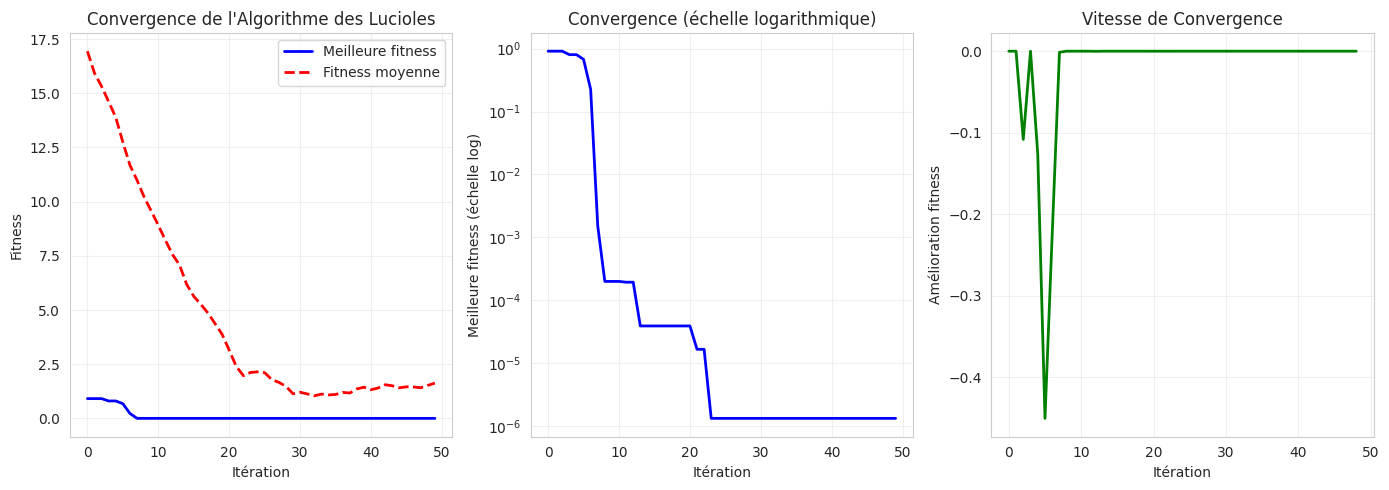


 Test Fonction Rosenbrock (2D)
 Firefly Algorithm initialisé:
    Lucioles: 25
    Itérations max: 100
    α=0.2, β₀=1.0, γ=1.0
 Fitness initiale: 23.071040
   Itération  0: Best=23.071040, Mean=11446.867733, α=0.198
   Itération  5: Best=5.673952, Mean=6789.385876, α=0.188
   Itération 10: Best=0.010884, Mean=2832.119854, α=0.179
   Itération 15: Best=0.000977, Mean=1478.778115, α=0.170
   Itération 20: Best=0.000977, Mean=877.889906, α=0.162
   Itération 25: Best=0.000545, Mean=929.934304, α=0.154
   Itération 30: Best=0.000219, Mean=672.453951, α=0.146
   Itération 35: Best=0.000219, Mean=593.670655, α=0.139
   Itération 40: Best=0.000008, Mean=400.725219, α=0.132
   Itération 45: Best=0.000008, Mean=291.443860, α=0.126
   Itération 50: Best=0.000001, Mean=463.979975, α=0.120
   Itération 55: Best=0.000001, Mean=187.877182, α=0.114
   Itération 60: Best=0.000001, Mean=116.406639, α=0.108
   Itération 65: Best=0.000001, Mean=131.508365, α=0.103
   Itération 70: Best=0.000001, Mean=1

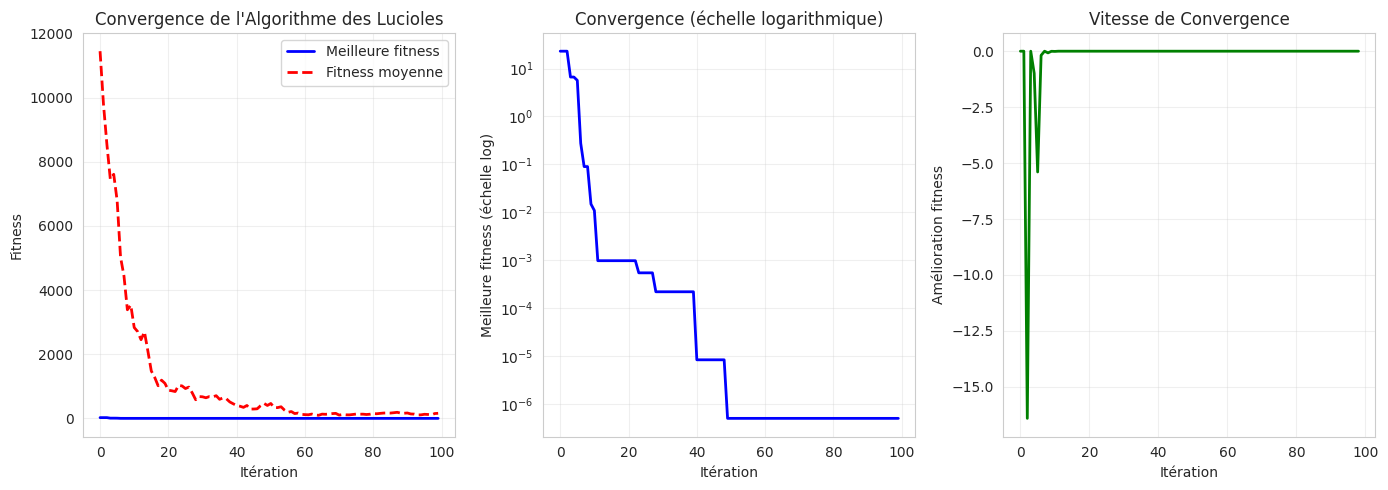


 TEST LOGIQUE FLOUE
------------------------------
 Évaluateur de logique floue initialisé
 Scénario Excellent:
   Accuracy: 0.95
   Convergence: 0.90
   Stabilité: 0.85
   → Qualité globale: 0.850 (Excellent)

 Scénario Bon:
   Accuracy: 0.85
   Convergence: 0.70
   Stabilité: 0.80
   → Qualité globale: 0.650 (Bon)

 Scénario Moyen:
   Accuracy: 0.75
   Convergence: 0.50
   Stabilité: 0.60
   → Qualité globale: 0.408 (Moyen)

 Scénario Faible:
   Accuracy: 0.60
   Convergence: 0.30
   Stabilité: 0.40
   → Qualité globale: 0.200 (Faible)

 TEST MODÈLE HMM
--------------------
 HMM d'optimisation initialisé:
    États: ['Exploration', 'Exploitation', 'Convergence']
    Seuils d'amélioration: {'high': np.float64(-0.09999999999999998), 'low': np.float64(-0.0010000000000000009)}
    Seuils de volatilité: {'high': np.float64(0.14790199457749043), 'low': np.float64(0.007395099728874527)}
 Test Exploration:
   Historique: [0.8, 0.9, 0.7, 1.0, 0.85]
   → Prédiction: Exploration (confiance: 0.

In [ ]:
class FireflyAlgorithm:
    """
    Implémentation de l'Algorithme des Lucioles (Firefly Algorithm)

    Inspiration biologique:
    - Les lucioles communiquent via la bioluminescence
    - Une luciole moins brillante est attirée par une plus brillante
    - L'intensité lumineuse diminue avec la distance
    - Mouvement combinant attraction et exploration aléatoire
    """

    def __init__(self,
                 n_fireflies: int = 20,
                 max_iterations: int = 100,
                 alpha: float = 0.2,      # Coefficient de randomisation
                 beta0: float = 1.0,      # Attractivité à distance 0
                 gamma: float = 1.0,      # Coefficient d'absorption
                 bounds: List[Tuple[float, float]] = None):
        """
        Paramètres:
        - n_fireflies: Nombre de lucioles dans l'essaim
        - max_iterations: Nombre maximum d'itérations
        - alpha: Coefficient de mouvement aléatoire (0-1)
        - beta0: Attractivité maximale
        - gamma: Coefficient d'absorption lumineuse
        - bounds: Limites de l'espace de recherche [(min, max), ...]
        """
        self.n_fireflies = n_fireflies
        self.max_iterations = max_iterations
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma
        self.bounds = bounds

        # Historique de convergence
        self.best_fitness_history = []
        self.mean_fitness_history = []

        print(f" Firefly Algorithm initialisé:")
        print(f"    Lucioles: {n_fireflies}")
        print(f"    Itérations max: {max_iterations}")
        print(f"    α={alpha}, β₀={beta0}, γ={gamma}")

    def initialize_population(self, n_dimensions: int) -> np.ndarray:
        """Initialise la population de lucioles dans l'espace de recherche"""
        if self.bounds is None:
            self.bounds = [(-5.0, 5.0)] * n_dimensions

        population = np.zeros((self.n_fireflies, n_dimensions))
        for i in range(self.n_fireflies):
            for j in range(n_dimensions):
                low, high = self.bounds[j]
                population[i, j] = np.random.uniform(low, high)

        return population

    def calculate_distance(self, firefly_i: np.ndarray, firefly_j: np.ndarray) -> float:
        """Calcule la distance euclidienne entre deux lucioles"""
        return np.sqrt(np.sum((firefly_i - firefly_j) ** 2))

    def calculate_attractiveness(self, distance: float) -> float:
        """
        Calcule l'attractivité en fonction de la distance
        Formule: β(r) = β₀ * e^(-γ * r²)
        """
        return self.beta0 * np.exp(-self.gamma * distance**2)

    def move_firefly(self, firefly_i: np.ndarray, firefly_j: np.ndarray,
                    attractiveness: float, n_dimensions: int) -> np.ndarray:
        """
        Déplace la luciole i vers la luciole j
        Formule: x_i^(t+1) = x_i^t + β(r)(x_j - x_i) + α * (rand - 0.5)
        """
        # Mouvement d'attraction vers la luciole plus brillante
        attraction_move = attractiveness * (firefly_j - firefly_i)

        # Mouvement aléatoire pour l'exploration
        random_move = self.alpha * (np.random.random(n_dimensions) - 0.5)

        # Nouvelle position
        new_position = firefly_i + attraction_move + random_move

        # Vérification des contraintes (bounds)
        for dim in range(n_dimensions):
            low, high = self.bounds[dim]
            new_position[dim] = np.clip(new_position[dim], low, high)

        return new_position

    def optimize(self, objective_function: Callable, n_dimensions: int) -> Tuple[np.ndarray, float]:
        """
        Optimise la fonction objectif

        Args:
            objective_function: Fonction à minimiser
            n_dimensions: Nombre de dimensions du problème

        Returns:
            best_solution: Meilleure solution trouvée
            best_fitness: Valeur de fitness de la meilleure solution
        """
        # Initialisation de la population
        fireflies = self.initialize_population(n_dimensions)
        fitness = np.array([objective_function(firefly) for firefly in fireflies])

        # Mémorisation de la meilleure solution
        best_idx = np.argmin(fitness)
        best_solution = fireflies[best_idx].copy()
        best_fitness = fitness[best_idx]

        print(f" Fitness initiale: {best_fitness:.6f}")

        # Boucle principale d'optimisation
        for iteration in range(self.max_iterations):
            # Pour chaque luciole
            for i in range(self.n_fireflies):
                # Comparer avec toutes les autres lucioles
                for j in range(self.n_fireflies):
                    # Si la luciole j est plus brillante (meilleure fitness)
                    if fitness[j] < fitness[i]:
                        # Calculer la distance
                        distance = self.calculate_distance(fireflies[i], fireflies[j])

                        # Calculer l'attractivité
                        attractiveness = self.calculate_attractiveness(distance)

                        # Déplacer la luciole i vers j
                        fireflies[i] = self.move_firefly(
                            fireflies[i], fireflies[j], attractiveness, n_dimensions
                        )

                        # Recalculer la fitness
                        fitness[i] = objective_function(fireflies[i])

            # Mise à jour de la meilleure solution
            current_best_idx = np.argmin(fitness)
            if fitness[current_best_idx] < best_fitness:
                best_solution = fireflies[current_best_idx].copy()
                best_fitness = fitness[current_best_idx]

            # Historique de convergence
            self.best_fitness_history.append(best_fitness)
            self.mean_fitness_history.append(np.mean(fitness))

            # Réduction adaptative du paramètre alpha (refroidissement)
            self.alpha *= 0.99

            # Affichage du progrès
            if iteration % 5 == 0:
                print(f"   Itération {iteration:2d}: Best={best_fitness:.6f}, Mean={np.mean(fitness):.6f}, α={self.alpha:.3f}")

        print(f" Optimisation terminée: {best_fitness:.6f}")
        return best_solution, best_fitness

    def plot_convergence(self):
        """Affiche les courbes de convergence"""
        if not self.best_fitness_history:
            print(" Aucun historique de convergence disponible")
            return

        plt.figure(figsize=(14, 5))

        plt.subplot(1, 3, 1)
        plt.plot(self.best_fitness_history, 'b-', linewidth=2, label='Meilleure fitness')
        plt.plot(self.mean_fitness_history, 'r--', linewidth=2, label='Fitness moyenne')
        plt.xlabel('Itération')
        plt.ylabel('Fitness')
        plt.title('Convergence de l\'Algorithme des Lucioles')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        plt.semilogy(self.best_fitness_history, 'b-', linewidth=2)
        plt.xlabel('Itération')
        plt.ylabel('Meilleure fitness (échelle log)')
        plt.title('Convergence (échelle logarithmique)')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 3)
        if len(self.best_fitness_history) > 1:
            improvements = np.diff(self.best_fitness_history)
            plt.plot(improvements, 'g-', linewidth=2)
            plt.xlabel('Itération')
            plt.ylabel('Amélioration fitness')
            plt.title('Vitesse de Convergence')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# =============================================================================
# LOGIQUE FLOUE POUR ÉVALUATION DES PARAMÈTRES
# =============================================================================

class FuzzyLogicEvaluator:
    """
    Évaluateur utilisant la logique floue pour qualifier les paramètres
    Évalue la performance globale en combinant accuracy, convergence et stabilité
    """

    def __init__(self):
        print(" Évaluateur de logique floue initialisé")

    def triangular_membership(self, x: float, a: float, b: float, c: float) -> float:
        """Fonction d'appartenance triangulaire"""
        if x <= a or x >= c:
            return 0.0
        elif a < x <= b:
            return (x - a) / (b - a)
        else:  # b < x < c
            return (c - x) / (c - b)

    def trapezoidal_membership(self, x: float, a: float, b: float, c: float, d: float) -> float:
        """Fonction d'appartenance trapézoïdale"""
        if x <= a or x >= d:
            return 0.0
        elif a < x <= b:
            return (x - a) / (b - a)
        elif b < x <= c:
            return 1.0
        else:  # c < x < d
            return (d - x) / (d - c)

    def evaluate_performance(self, accuracy: float, convergence_speed: float,
                           stability: float) -> Dict[str, float]:
        """
        Évalue la performance globale avec logique floue

        Args:
            accuracy: Précision du modèle [0, 1]
            convergence_speed: Vitesse de convergence normalisée [0, 1]
            stability: Stabilité de la convergence [0, 1]

        Returns:
            Dictionnaire avec évaluations floues et score global
        """
        # === ENSEMBLES FLOUS POUR ACCURACY ===
        acc_low = self.trapezoidal_membership(accuracy, 0, 0, 0.6, 0.8)
        acc_medium = self.triangular_membership(accuracy, 0.6, 0.8, 0.95)
        acc_high = self.trapezoidal_membership(accuracy, 0.8, 0.95, 1.0, 1.0)

        # === ENSEMBLES FLOUS POUR CONVERGENCE ===
        conv_slow = self.trapezoidal_membership(convergence_speed, 0, 0, 0.3, 0.6)
        conv_medium = self.triangular_membership(convergence_speed, 0.3, 0.6, 0.8)
        conv_fast = self.trapezoidal_membership(convergence_speed, 0.6, 0.8, 1.0, 1.0)

        # === ENSEMBLES FLOUS POUR STABILITÉ ===
        stab_low = self.trapezoidal_membership(stability, 0, 0, 0.4, 0.7)
        stab_medium = self.triangular_membership(stability, 0.4, 0.7, 0.9)
        stab_high = self.trapezoidal_membership(stability, 0.7, 0.9, 1.0, 1.0)

        # === RÈGLES FLOUES ===
        # Règle 1: Si accuracy=high ET convergence=fast ET stabilité=high -> excellent
        excellent = min(acc_high, conv_fast, stab_high)

        # Règle 2: Si accuracy=high ET (convergence=medium OU stabilité=medium) -> good
        good = min(acc_high, max(conv_medium, stab_medium))

        # Règle 3: Si accuracy=medium -> average
        average = acc_medium

        # Règle 4: Si accuracy=low OU stabilité=low -> poor
        poor = max(acc_low, stab_low)

        # === DÉFUZZIFICATION (Centre de gravité) ===
        quality_levels = [0.2, 0.5, 0.7, 0.9]  # poor, average, good, excellent
        memberships = [poor, average, good, excellent]

        numerator = sum(q * m for q, m in zip(quality_levels, memberships))
        denominator = sum(memberships)

        overall_quality = numerator / denominator if denominator > 0 else 0.5

        return {
            'accuracy_memberships': {
                'low': acc_low, 'medium': acc_medium, 'high': acc_high
            },
            'convergence_memberships': {
                'slow': conv_slow, 'medium': conv_medium, 'fast': conv_fast
            },
            'stability_memberships': {
                'low': stab_low, 'medium': stab_medium, 'high': stab_high
            },
            'quality_scores': {
                'poor': poor, 'average': average, 'good': good, 'excellent': excellent
            },
            'overall_quality': overall_quality
        }

    def interpret_quality(self, overall_quality: float) -> str:
        """Interprète le score de qualité globale"""
        if overall_quality >= 0.8:
            return "Excellent"
        elif overall_quality >= 0.6:
            return "Bon"
        elif overall_quality >= 0.4:
            return "Moyen"
        else:
            return "Faible"

# =============================================================================
# MODÈLE HMM POUR PRÉDICTION DES ÉTATS D'OPTIMISATION
# =============================================================================

class OptimizationHMM:
    """
    Modèle de Markov Caché pour modéliser les états d'optimisation
    États: 0=Exploration, 1=Exploitation, 2=Convergence
    """

    def __init__(self, n_states: int = 3):
        self.n_states = n_states
        self.state_names = {
            0: "Exploration",    # Recherche globale, fitness très variable
            1: "Exploitation",   # Amélioration locale, fitness s'améliore
            2: "Convergence"     # Stabilisation, fitness stable
        }
        self.is_fitted = False

        # Paramètres HMM simplifiés
        self.transition_matrix = None
        self.emission_params = None

        print(f" HMM d'optimisation initialisé:")
        print(f"    États: {list(self.state_names.values())}")

    def analyze_optimization_patterns(self, histories: List[List[float]]):
        """Analyse les patterns d'optimisation pour entraîner le HMM"""
        if not histories:
            return

        all_improvements = []
        all_volatilities = []

        for history in histories:
            if len(history) > 2:
                # Calcul des améliorations
                improvements = np.diff(history)  # Négatif = amélioration (minimisation)
                all_improvements.extend(improvements)

                # Calcul de la volatilité (fenêtre glissante)
                for i in range(2, len(history)):
                    window = history[max(0, i-3):i+1]
                    volatility = np.std(window)
                    all_volatilities.append(volatility)

        if all_improvements and all_volatilities:
            # Seuils pour classification des états
            self.improvement_thresholds = {
                'high': np.percentile(all_improvements, 25),  # 25% meilleures améliorations
                'low': np.percentile(all_improvements, 75)    # 75% améliorations moyennes
            }

            self.volatility_thresholds = {
                'high': np.percentile(all_volatilities, 75),  # 75% plus volatiles
                'low': np.percentile(all_volatilities, 25)    # 25% plus stables
            }

            self.is_fitted = True

            print(f"    Seuils d'amélioration: {self.improvement_thresholds}")
            print(f"    Seuils de volatilité: {self.volatility_thresholds}")

    def predict_state(self, recent_history: List[float]) -> Tuple[int, float, str]:
        """
        Prédit l'état d'optimisation basé sur l'historique récent

        Returns:
            state: État prédit (0, 1, 2)
            confidence: Confiance de la prédiction [0, 1]
            explanation: Explication textuelle
        """
        if not self.is_fitted or len(recent_history) < 3:
            return 0, 0.5, "Données insuffisantes - État Exploration par défaut"

        # Analyser les 5 dernières valeurs
        recent = recent_history[-5:]

        # Calcul des métriques
        recent_improvement = np.mean(np.diff(recent))  # Amélioration moyenne récente
        recent_volatility = np.std(recent)             # Volatilité récente
        trend = np.polyfit(range(len(recent)), recent, 1)[0]  # Tendance linéaire

        # Classification floue des états
        exploration_score = 0.0
        exploitation_score = 0.0
        convergence_score = 0.0

        # === ÉTAT EXPLORATION ===
        # Haute volatilité, pas d'amélioration claire
        if recent_volatility > self.volatility_thresholds['high']:
            exploration_score += 0.4
        if abs(recent_improvement) < abs(self.improvement_thresholds['high']) * 0.5:
            exploration_score += 0.3
        if abs(trend) < abs(self.improvement_thresholds['high']) * 0.3:
            exploration_score += 0.3

        # === ÉTAT EXPLOITATION ===
        # Amélioration constante, volatilité modérée
        if recent_improvement < self.improvement_thresholds['high']:  # Bonne amélioration
            exploitation_score += 0.5
        if (self.volatility_thresholds['low'] < recent_volatility < self.volatility_thresholds['high']):
            exploitation_score += 0.3
        if trend < self.improvement_thresholds['high'] * 0.5:  # Tendance d'amélioration
            exploitation_score += 0.2

        # === ÉTAT CONVERGENCE ===
        # Faible volatilité, améliorations minimes
        if recent_volatility < self.volatility_thresholds['low']:
            convergence_score += 0.4
        if abs(recent_improvement) < abs(self.improvement_thresholds['low']) * 0.5:
            convergence_score += 0.4
        if abs(trend) < abs(self.improvement_thresholds['low']) * 0.3:
            convergence_score += 0.2

        # Déterminer l'état et la confiance
        scores = [exploration_score, exploitation_score, convergence_score]
        predicted_state = np.argmax(scores)
        confidence = max(scores)

        # Normaliser la confiance
        confidence = min(confidence, 1.0)

        # Explication
        explanations = {
            0: f"Exploration (volatilité={recent_volatility:.3f}, amélioration={recent_improvement:.3f})",
            1: f"Exploitation (amélioration={recent_improvement:.3f}, tendance={trend:.3f})",
            2: f"Convergence (stabilité={1/max(recent_volatility, 1e-6):.1f}, plateau détecté)"
        }

        explanation = explanations[predicted_state]

        return predicted_state, confidence, explanation

    def get_optimization_advice(self, state: int, confidence: float) -> str:
        """Donne des conseils d'optimisation basés sur l'état prédit"""
        advice = {
            0: " Phase d'Exploration - Augmenter α (randomisation), réduire γ (attraction)",
            1: " Phase d'Exploitation - Équilibrer α et γ, maintenir la diversité",
            2: " Phase de Convergence - Réduire α, augmenter γ pour affinage local"
        }

        confidence_level = "Forte" if confidence > 0.7 else "Modérée" if confidence > 0.4 else "Faible"

        return f"{advice[state]} (Confiance: {confidence_level})"

# =============================================================================
# OPTIMISEUR HYBRIDE FIREFLY + FUZZY + HMM
# =============================================================================

class HybridFireflyOptimizer:
    """
    Optimiseur hybride combinant:
    - Algorithme des Lucioles pour l'optimisation
    - Logique Floue pour l'évaluation des performances
    - HMM pour la prédiction et adaptation des états
    """

    def __init__(self,
                 firefly_params: Dict[str, Any] = None,
                 use_fuzzy: bool = True,
                 use_hmm: bool = True,
                 adaptive_params: bool = True,
                 verbose: bool = True):

        # Paramètres par défaut de l'algorithme des lucioles
        default_firefly_params = {
            'n_fireflies': 15,
            'max_iterations': 30,
            'alpha': 0.2,
            'beta0': 1.0,
            'gamma': 1.0
        }

        if firefly_params:
            default_firefly_params.update(firefly_params)

        self.firefly_params = default_firefly_params
        self.use_fuzzy = use_fuzzy
        self.use_hmm = use_hmm
        self.adaptive_params = adaptive_params
        self.verbose = verbose

        # Composants hybrides
        self.fuzzy_evaluator = FuzzyLogicEvaluator() if use_fuzzy else None
        self.hmm_model = OptimizationHMM() if use_hmm else None

        # Historiques pour apprentissage
        self.optimization_histories = []
        self.current_history = []

        # Métriques de suivi
        self.fuzzy_evaluations = []
        self.hmm_predictions = []
        self.parameter_adaptations = []

        print(f" Optimiseur Hybride initialisé:")
        print(f"    Firefly: {self.firefly_params}")
        print(f"    Logique Floue: {'yes' if use_fuzzy else 'no'}")
        print(f"    HMM: {'yes' if use_hmm else 'no'}")
        print(f"    Adaptation: {'yes' if adaptive_params else 'no'}")

    def train_hmm(self, histories: List[List[float]]):
        """Entraîner le modèle HMM avec les historiques d'optimisation"""
        if self.use_hmm and self.hmm_model and histories:
            print(" Entraînement du modèle HMM")
            self.hmm_model.analyze_optimization_patterns(histories)
            print(" HMM entraîné")

    def adaptive_parameter_adjustment(self, iteration: int, fitness_history: List[float]) -> Dict[str, float]:
        """
        Ajustement adaptatif des paramètres basé sur l'état HMM et l'évaluation floue
        """
        adapted_params = self.firefly_params.copy()

        if len(fitness_history) < 3:
            return adapted_params

        # === PRÉDICTION HMM ===
        if self.use_hmm and self.hmm_model and self.hmm_model.is_fitted:
            try:
                state, confidence, explanation = self.hmm_model.predict_state(fitness_history)
                state_name = self.hmm_model.state_names[state]

                self.hmm_predictions.append({
                    'iteration': iteration,
                    'state': state,
                    'state_name': state_name,
                    'confidence': confidence,
                    'explanation': explanation
                })

                if self.verbose and iteration % 5 == 0:
                    print(f"    HMM: {state_name} ({confidence:.3f}) - {explanation}")

                # Ajustement des paramètres selon l'état
                if state == 0:  # Exploration
                    adapted_params['alpha'] = min(0.5, self.firefly_params['alpha'] * 1.5)
                    adapted_params['gamma'] = max(0.5, self.firefly_params['gamma'] * 0.8)
                elif state == 1:  # Exploitation
                    adapted_params['alpha'] = self.firefly_params['alpha'] * 1.0
                    adapted_params['gamma'] = self.firefly_params['gamma'] * 1.2
                elif state == 2:  # Convergence
                    adapted_params['alpha'] = self.firefly_params['alpha'] * 0.5
                    adapted_params['gamma'] = self.firefly_params['gamma'] * 1.5

            except Exception as e:
                if self.verbose:
                    print(f"    Erreur HMM: {e}")

        # === RÉDUCTION PROGRESSIVE ALPHA ===
        if self.adaptive_params:
            progress = iteration / self.firefly_params['max_iterations']
            alpha_decay = 0.98 ** iteration
            adapted_params['alpha'] *= alpha_decay

        # Enregistrer les adaptations
        self.parameter_adaptations.append({
            'iteration': iteration,
            'alpha': adapted_params['alpha'],
            'gamma': adapted_params['gamma']
        })

        return adapted_params

    def calculate_convergence_metrics(self, fitness_history: List[float]) -> Tuple[float, float]:
        """Calcule les métriques de convergence pour l'évaluation floue"""
        if len(fitness_history) < 5:
            return 0.5, 0.5

        # Vitesse de convergence (amélioration normalisée)
        initial_fitness = fitness_history[0]
        current_fitness = fitness_history[-1]
        improvement = (initial_fitness - current_fitness) / max(abs(initial_fitness), 1e-8)
        convergence_speed = min(max(improvement * 5, 0), 1)  # Normaliser [0, 1]

        # Stabilité (inverse de la variance récente)
        recent_window = fitness_history[-5:]
        variance = np.var(recent_window)
        stability = 1.0 / (1.0 + variance * 100)  # Normaliser [0, 1]

        return convergence_speed, stability

    def plot_optimization_analysis(self, optimization_result: Dict[str, Any]):
        """Visualise l'analyse complète de l'optimisation hybride"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # 1. Convergence
        if 'convergence_curve' in optimization_result:
            axes[0, 0].plot(optimization_result['convergence_curve'], 'b-', linewidth=2)
            axes[0, 0].set_title('Convergence de l\'Algorithme Hybride')
            axes[0, 0].set_xlabel('Itération')
            axes[0, 0].set_ylabel('Fitness')
            axes[0, 0].grid(True, alpha=0.3)

        # 2. Adaptations des paramètres
        if self.parameter_adaptations:
            iterations = [p['iteration'] for p in self.parameter_adaptations]
            alphas = [p['alpha'] for p in self.parameter_adaptations]
            gammas = [p['gamma'] for p in self.parameter_adaptations]

            axes[0, 1].plot(iterations, alphas, 'r-', linewidth=2, label='α (randomisation)')
            axes[0, 1].plot(iterations, gammas, 'g-', linewidth=2, label='γ (absorption)')
            axes[0, 1].set_title('Adaptation des Paramètres')
            axes[0, 1].set_xlabel('Itération')
            axes[0, 1].set_ylabel('Valeur des paramètres')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # 3. États HMM
        if self.hmm_predictions:
            iterations = [p['iteration'] for p in self.hmm_predictions]
            states = [p['state'] for p in self.hmm_predictions]
            confidences = [p['confidence'] for p in self.hmm_predictions]

            scatter = axes[0, 2].scatter(iterations, states, c=confidences,
                                       cmap='viridis', s=60, alpha=0.8)
            axes[0, 2].set_title('Prédictions HMM')
            axes[0, 2].set_xlabel('Itération')
            axes[0, 2].set_ylabel('État')
            axes[0, 2].set_yticks([0, 1, 2])
            axes[0, 2].set_yticklabels(['Exploration', 'Exploitation', 'Convergence'])
            plt.colorbar(scatter, ax=axes[0, 2], label='Confiance')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Évaluations floues
        if self.fuzzy_evaluations:
            qualities = [eval_result['overall_quality'] for eval_result in self.fuzzy_evaluations]
            axes[1, 0].bar(range(len(qualities)), qualities, color='purple', alpha=0.7)
            axes[1, 0].set_title('Évaluations de Qualité Floue')
            axes[1, 0].set_xlabel('Évaluation')
            axes[1, 0].set_ylabel('Qualité Globale')
            axes[1, 0].set_ylim(0, 1)
            axes[1, 0].grid(True, alpha=0.3)

        # 5. Distribution des états HMM
        if self.hmm_predictions:
            state_counts = {0: 0, 1: 0, 2: 0}
            for pred in self.hmm_predictions:
                state_counts[pred['state']] += 1

            state_names = ['Exploration', 'Exploitation', 'Convergence']
            counts = [state_counts[i] for i in range(3)]
            colors = ['red', 'orange', 'green']

            axes[1, 1].pie(counts, labels=state_names, colors=colors, autopct='%1.1f%%')
            axes[1, 1].set_title('Distribution des États HMM')

        # 6. Performance finale vs objectif
        if 'best_score' in optimization_result:
            final_score = optimization_result['best_score']
            target_score = 0.9  # Score cible

            bars = axes[1, 2].bar(['Score Final', 'Objectif'], [final_score, target_score],
                                 color=['darkblue', 'lightgray'], alpha=0.8)
            axes[1, 2].set_title('Performance vs Objectif')
            axes[1, 2].set_ylabel('Score')
            axes[1, 2].set_ylim(0, 1)

            # Annotation
            for bar, score in zip(bars, [final_score, target_score]):
                axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                               f'{score:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()



# =============================================================================
# TESTS DE L'ALGORITHME DES LUCIOLES
# =============================================================================

def test_firefly_on_benchmark():
    """Test de l'algorithme des lucioles sur fonctions benchmark"""
    print(" TEST ALGORITHME DES LUCIOLES - FONCTIONS BENCHMARK")
    print("-" * 60)

    # Fonction de Sphere (optimum global à l'origine)
    def sphere_function(x):
        return np.sum(x**2)

    # Fonction de Rosenbrock (optimum global à [1, 1, ...])
    def rosenbrock_function(x):
        if len(x) < 2:
            return 0
        return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

    # Test sur fonction Sphere
    print("\n Test Fonction Sphere (2D)")
    fa_sphere = FireflyAlgorithm(
        n_fireflies=20,
        max_iterations=50,
        alpha=0.2,
        beta0=1.0,
        gamma=1.0,
        bounds=[(-5, 5)] * 2
    )

    best_sol_sphere, best_fit_sphere = fa_sphere.optimize(sphere_function, 2)
    print(f" Meilleure solution: {best_sol_sphere}")
    print(f" Meilleure fitness: {best_fit_sphere:.8f}")
    print(f" Erreur vs optimum: {np.sqrt(np.sum(best_sol_sphere**2)):.8f}")

    fa_sphere.plot_convergence()

    # Test sur fonction Rosenbrock
    print(f"\n Test Fonction Rosenbrock (2D)")
    fa_rosenbrock = FireflyAlgorithm(
        n_fireflies=25,
        max_iterations=100,
        alpha=0.2,
        beta0=1.0,
        gamma=1.0,
        bounds=[(-5, 5)] * 2
    )

    best_sol_rosenbrock, best_fit_rosenbrock = fa_rosenbrock.optimize(rosenbrock_function, 2)
    print(f" Meilleure solution: {best_sol_rosenbrock}")
    print(f" Meilleure fitness: {best_fit_rosenbrock:.8f}")
    print(f" Erreur vs optimum [1,1]: {np.sqrt(np.sum((best_sol_rosenbrock - 1)**2)):.8f}")

    fa_rosenbrock.plot_convergence()

    return {
        'sphere': {'solution': best_sol_sphere, 'fitness': best_fit_sphere},
        'rosenbrock': {'solution': best_sol_rosenbrock, 'fitness': best_fit_rosenbrock}
    }

def test_fuzzy_logic():
    """Test du système de logique floue"""
    print("\n TEST LOGIQUE FLOUE")
    print("-" * 30)

    fuzzy_eval = FuzzyLogicEvaluator()

    # Scénarios de test
    test_scenarios = [
        {'name': 'Excellent', 'accuracy': 0.95, 'convergence': 0.9, 'stability': 0.85},
        {'name': 'Bon', 'accuracy': 0.85, 'convergence': 0.7, 'stability': 0.8},
        {'name': 'Moyen', 'accuracy': 0.75, 'convergence': 0.5, 'stability': 0.6},
        {'name': 'Faible', 'accuracy': 0.6, 'convergence': 0.3, 'stability': 0.4},
    ]

    for scenario in test_scenarios:
        result = fuzzy_eval.evaluate_performance(
            scenario['accuracy'], scenario['convergence'], scenario['stability']
        )

        interpretation = fuzzy_eval.interpret_quality(result['overall_quality'])

        print(f" Scénario {scenario['name']}:")
        print(f"   Accuracy: {scenario['accuracy']:.2f}")
        print(f"   Convergence: {scenario['convergence']:.2f}")
        print(f"   Stabilité: {scenario['stability']:.2f}")
        print(f"   → Qualité globale: {result['overall_quality']:.3f} ({interpretation})")
        print()

def test_hmm_states():
    """Test du modèle HMM pour prédiction d'états"""
    print(" TEST MODÈLE HMM")
    print("-" * 20)

    hmm_model = OptimizationHMM()

    # Historiques d'optimisation simulés
    exploration_history = [1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.0, 0.85]  # Très variable
    exploitation_history = [1.0, 0.8, 0.7, 0.6, 0.55, 0.5, 0.48, 0.45]  # Amélioration constante
    convergence_history = [0.5, 0.49, 0.48, 0.485, 0.48, 0.479, 0.478, 0.477]  # Stabilisé

    # Entraînement
    training_histories = [exploration_history, exploitation_history, convergence_history] * 3
    hmm_model.analyze_optimization_patterns(training_histories)

    # Tests de prédiction
    test_cases = [
        {'name': 'Exploration', 'history': [0.8, 0.9, 0.7, 1.0, 0.85]},
        {'name': 'Exploitation', 'history': [1.0, 0.8, 0.6, 0.5, 0.4]},
        {'name': 'Convergence', 'history': [0.3, 0.29, 0.285, 0.28, 0.279]}
    ]

    for test_case in test_cases:
        state, confidence, explanation = hmm_model.predict_state(test_case['history'])
        predicted_name = hmm_model.state_names[state]
        advice = hmm_model.get_optimization_advice(state, confidence)

        print(f" Test {test_case['name']}:")
        print(f"   Historique: {test_case['history']}")
        print(f"   → Prédiction: {predicted_name} (confiance: {confidence:.3f})")
        print(f"   → Explication: {explanation}")
        print(f"   → Conseil: {advice}")
        print()

# =============================================================================
# EXÉCUTION DES TESTS
# =============================================================================

print(" TESTS DES COMPOSANTS INDIVIDUELS")
print("="*50)

# Test 1: Algorithme des Lucioles
benchmark_results = test_firefly_on_benchmark()

# Test 2: Logique Floue
test_fuzzy_logic()

# Test 3: HMM
test_hmm_states()

# =============================================================================
# INITIALISATION DE L'OPTIMISEUR HYBRIDE
# =============================================================================

print("\n INITIALISATION OPTIMISEUR HYBRIDE")
print("="*50)

# Créer l'optimiseur hybride avec tous les composants
hybrid_optimizer = HybridFireflyOptimizer(
    firefly_params={
        'n_fireflies': 15,
        'max_iterations': 25,
        'alpha': 0.2,
        'beta0': 1.0,
        'gamma': 1.0
    },
    use_fuzzy=True,
    use_hmm=True,
    adaptive_params=True,
    verbose=True
)

# Simuler des historiques d'optimisation précédentes pour l'entraînement HMM
print("\n Génération d'historiques d'entraînement pour HMM...")

synthetic_histories = []

# Générer différents types d'historiques
for _ in range(3):
    # Historique type "exploration puis exploitation puis convergence"
    exploration_phase = np.random.uniform(0.8, 1.2, 8)  # Phase chaotique
    exploitation_phase = np.linspace(0.8, 0.4, 10) + np.random.normal(0, 0.02, 10)  # Amélioration
    convergence_phase = np.random.normal(0.35, 0.01, 7)  # Stabilisation

    full_history = np.concatenate([exploration_phase, exploitation_phase, convergence_phase])
    synthetic_histories.append(full_history.tolist())

# Ajouter quelques historiques plus courts et variés
for _ in range(2):
    short_history = np.linspace(0.9, 0.3, 15) + np.random.normal(0, 0.05, 15)
    synthetic_histories.append(short_history.tolist())

print(f" {len(synthetic_histories)} historiques générés pour l'entraînement")

# Entraîner le modèle HMM
hybrid_optimizer.train_hmm(synthetic_histories)



Streaming output truncated to the last 5000 lines.
 Entraînement MLP...
    Architecture: (128, 64)
    Activation: relu
    Learning rate: 0.0006506688166570321
    Score validation: 0.2308
    Temps: 0.35s
    Itérations: 62
   🔍 Évaluation 111: {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'learning_rate': np.float64(0.0018875263232320549), 'max_iter': 233}
 Entraînement MLP...
    Architecture: (128, 64)
    Activation: relu
    Learning rate: 0.0018875263232320549
    Score validation: 0.1946
    Temps: 0.26s
    Itérations: 51
 Entraînement MLP...
    Architecture: (128, 64)
    Activation: relu
    Learning rate: 0.0019283613364329156
    Score validation: 0.1674
    Temps: 0.11s
    Itérations: 22
 Entraînement MLP...
    Architecture: (256, 128)
    Activation: relu
    Learning rate: 0.0012644178627088957
    Score validation: 0.1674
    Temps: 0.24s
    Itérations: 23
   🔍 Évaluation 114: {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'learning_rate': np.f

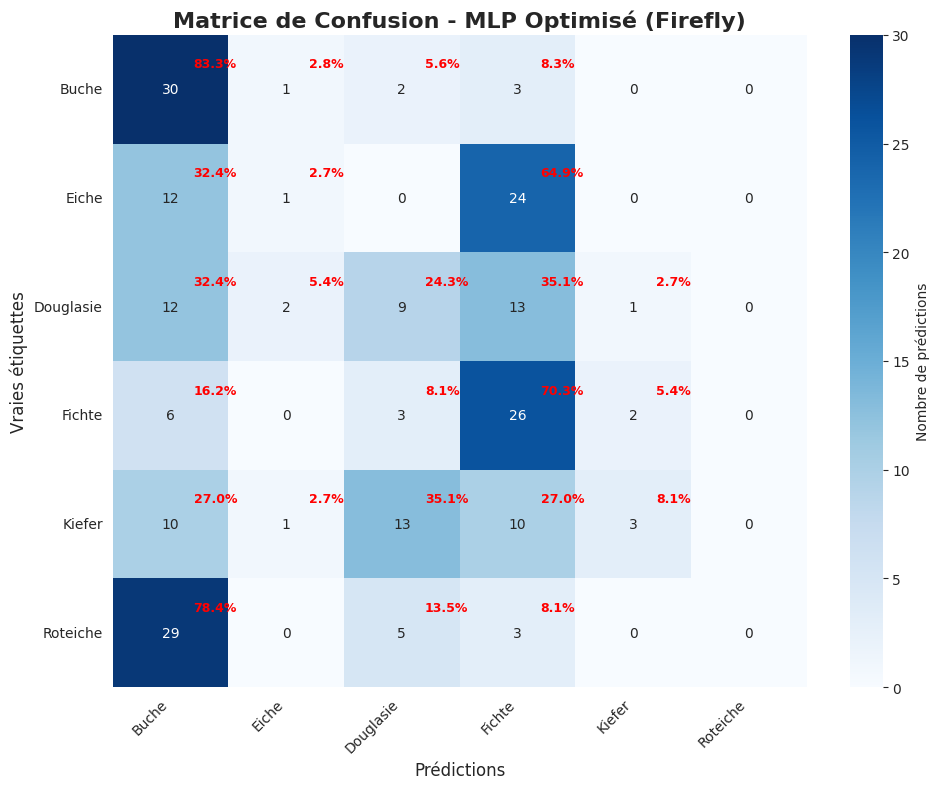

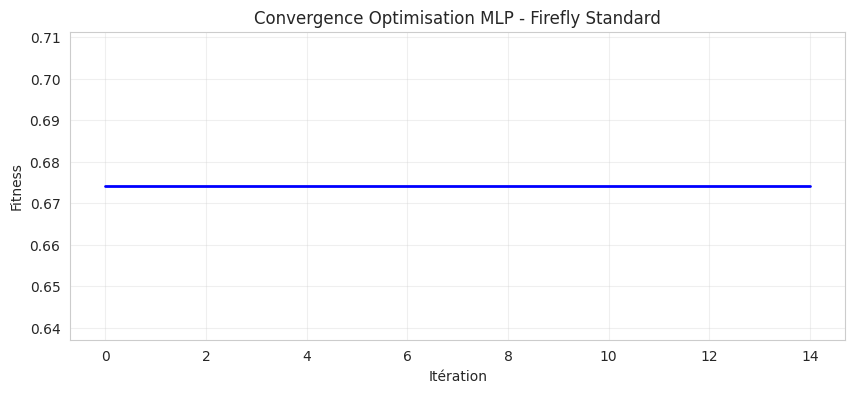


🌟 OPTIMISATION MLP AVEC FIREFLY HYBRIDE
--------------------------------------------------
🔄 Lancement de l'optimisation hybride...
 Firefly Algorithm initialisé:
    Lucioles: 8
    Itérations max: 12
    α=0.2, β₀=1.0, γ=1.0
 Entraînement MLP...
    Architecture: (128,)
    Activation: relu
    Learning rate: 0.007130443152704601
    Temps: 0.08s
    Itérations: 22
 Entraînement MLP...
    Architecture: (128,)
    Activation: relu
    Learning rate: 0.000841143871792529
    Temps: 0.13s
    Itérations: 37
 Entraînement MLP...
    Architecture: (256, 128)
    Activation: relu
    Learning rate: 0.0015544498990661799
    Temps: 0.55s
    Itérations: 55
 Entraînement MLP...
    Architecture: (256, 128)
    Activation: tanh
    Learning rate: 0.00031189833537843505
    Temps: 1.16s
    Itérations: 50
 Entraînement MLP...
    Architecture: (128, 64)
    Activation: relu
    Learning rate: 0.00925122140910426
    Temps: 0.17s
    Itérations: 28
 Entraînement MLP...
    Architecture: (256,

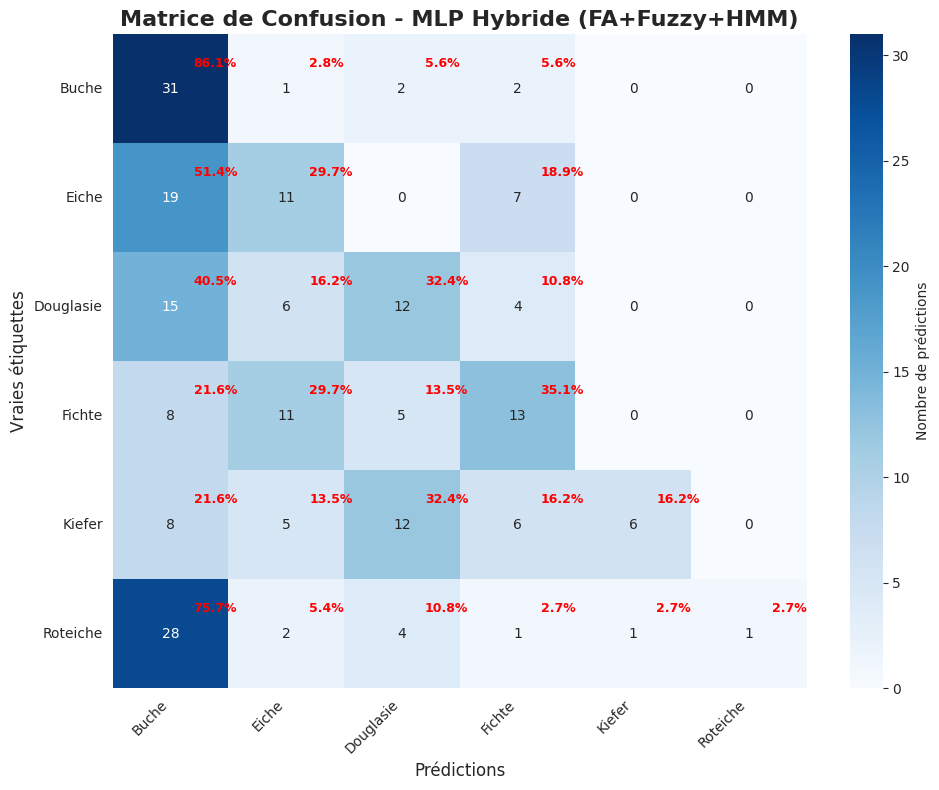

🔮 Évaluation floue: 0.200
   Interprétation: Faible


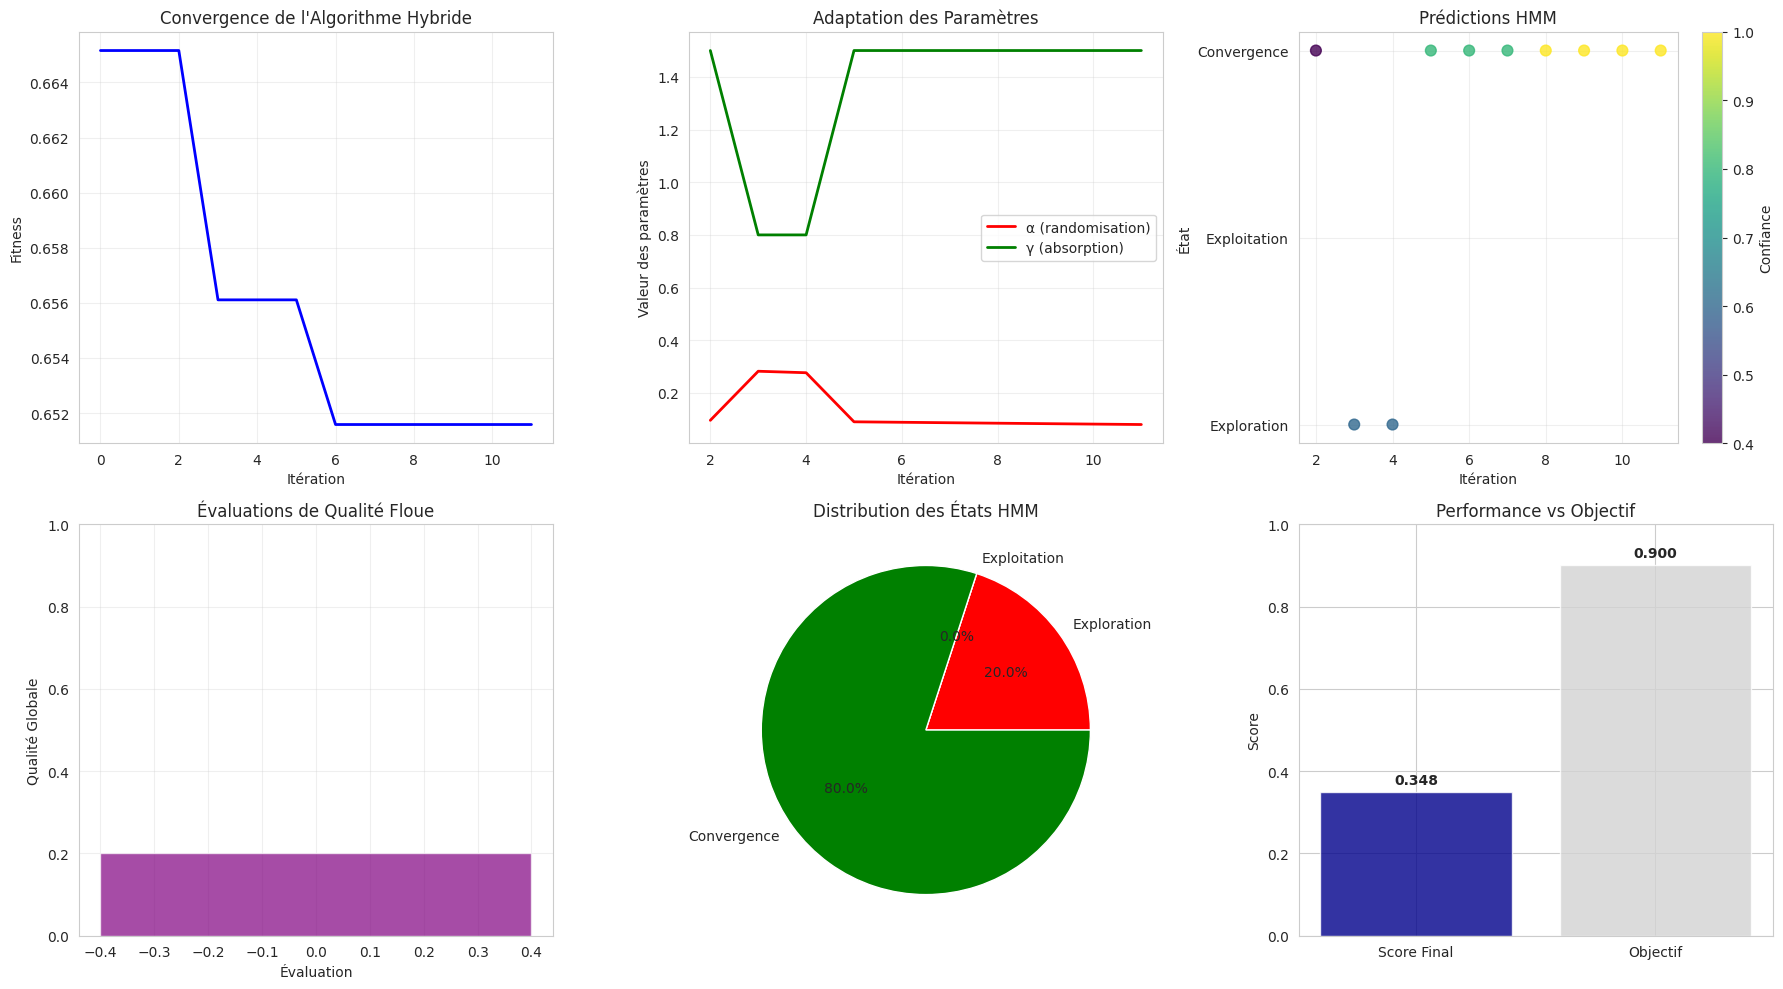

✅ Optimisation hybride terminée:
   🏆 Paramètres: {'hidden_layer_sizes': (256, 128), 'activation': 'tanh', 'learning_rate': np.float64(0.00012434991664859188)}
   🎯 Score: 0.3484
   ⏱️ Temps: 379.33s

🔗 OPTIMISATION DGCNN AVEC FIREFLY
----------------------------------------
🔥 OPTIMISATION FIREFLY - DGCNNTrainer
   📊 Paramètres: ['k', 'dropout_rate', 'learning_rate']
   🔧 Configuration: {'n_fireflies': 6, 'max_iterations': 8, 'alpha': 0.2, 'beta0': 1.0, 'gamma': 1.0}
   📐 Espace de recherche: 3 dimensions
 Firefly Algorithm initialisé:
    Lucioles: 6
    Itérations max: 8
    α=0.2, β₀=1.0, γ=1.0
 Entraînement DGCNN...
    Architecture: k=12, dropout=0.48385895110939525
    Batch size: 16, epochs: 10
    Device: cuda
   Époque   0: Train 40.48%, Val 30.32%
   Époque   5: Train 71.45%, Val 61.54%
   Époque   9: Train 73.56%, Val 49.77%
    Meilleure accuracy: 61.54%
    Temps: 75.44s
   🎯 Nouveau record: 0.6154
 Entraînement DGCNN...
    Architecture: k=11, dropout=0.42026168096578737


In [ ]:
# =======================================================================================
# CELLULE 5 - APPLICATION DE L'OPTIMISATION DES HYPERPARAMÈTRES
# =======================================================================================

print("🎯 APPLICATION DE L'OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

# =============================================================================
# OPTIMISEUR D'HYPERPARAMÈTRES AVEC FIREFLY
# =============================================================================

@dataclass
class OptimizationResult:
    """Classe pour stocker les résultats d'optimisation"""
    best_params: Dict[str, Any]
    best_score: float
    optimization_history: List[float]
    convergence_curve: List[float]
    total_time: float
    n_evaluations: int
    method: str = "Firefly"

class HyperparameterOptimizer:
    """
    Optimiseur d'hyperparamètres utilisant l'Algorithme des Lucioles
    Compatible avec MLP et DGCNN
    """

    def __init__(self,
                 firefly_params: Dict[str, Any] = None,
                 cv_folds: int = 3,
                 scoring: str = 'accuracy',
                 verbose: bool = True,
                 random_state: int = 42):

        # Paramètres par défaut
        default_firefly_params = {
            'n_fireflies': 12,
            'max_iterations': 20,
            'alpha': 0.2,
            'beta0': 1.0,
            'gamma': 1.0
        }

        if firefly_params:
            default_firefly_params.update(firefly_params)

        self.firefly_params = default_firefly_params
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.verbose = verbose
        self.random_state = random_state

        # Suivi des évaluations
        self.evaluation_counter = 0
        self.best_score_history = []

    def encode_params(self, params: Dict[str, Any], param_space: Dict[str, Dict]) -> np.ndarray:
        """Encode les paramètres en vecteur numérique pour l'optimisation"""
        encoded = []

        for param_name, param_info in param_space.items():
            value = params[param_name]
            param_type = param_info['type']

            if param_type == 'int':
                min_val, max_val = param_info['range']
                normalized = (value - min_val) / (max_val - min_val)
                encoded.append(normalized)

            elif param_type == 'float':
                min_val, max_val = param_info['range']
                normalized = (value - min_val) / (max_val - min_val)
                encoded.append(normalized)

            elif param_type == 'categorical':
                choices = param_info['choices']
                one_hot = [0.0] * len(choices)
                if value in choices:
                    idx = choices.index(value)
                    one_hot[idx] = 1.0
                encoded.extend(one_hot)

            elif param_type == 'log':
                min_val, max_val = param_info['range']
                log_min, log_max = np.log10(min_val), np.log10(max_val)
                log_value = np.log10(max(value, 1e-10))
                normalized = (log_value - log_min) / (log_max - log_min)
                encoded.append(np.clip(normalized, 0, 1))

        return np.array(encoded)

    def decode_params(self, encoded: np.ndarray, param_space: Dict[str, Dict]) -> Dict[str, Any]:
        """Décode un vecteur numérique en paramètres"""
        params = {}
        idx = 0

        for param_name, param_info in param_space.items():
            param_type = param_info['type']

            if param_type == 'int':
                min_val, max_val = param_info['range']
                normalized = np.clip(encoded[idx], 0, 1)
                value = int(round(min_val + normalized * (max_val - min_val)))
                params[param_name] = value
                idx += 1

            elif param_type == 'float':
                min_val, max_val = param_info['range']
                normalized = np.clip(encoded[idx], 0, 1)
                value = min_val + normalized * (max_val - min_val)
                params[param_name] = value
                idx += 1

            elif param_type == 'categorical':
                choices = param_info['choices']
                n_choices = len(choices)
                one_hot_values = encoded[idx:idx+n_choices]
                choice_idx = np.argmax(one_hot_values)
                params[param_name] = choices[choice_idx]
                idx += n_choices

            elif param_type == 'log':
                min_val, max_val = param_info['range']
                log_min, log_max = np.log10(min_val), np.log10(max_val)
                normalized = np.clip(encoded[idx], 0, 1)
                log_value = log_min + normalized * (log_max - log_min)
                value = 10 ** log_value
                params[param_name] = value
                idx += 1

        return params

    def calculate_dimensions(self, param_space: Dict[str, Dict]) -> int:
        """Calcule le nombre de dimensions pour l'encodage"""
        dimensions = 0
        for param_name, param_info in param_space.items():
            param_type = param_info['type']
            if param_type in ['int', 'float', 'log']:
                dimensions += 1
            elif param_type == 'categorical':
                dimensions += len(param_info['choices'])
        return dimensions

    def create_objective_function(self, model, X_train: np.ndarray, y_train: np.ndarray,
                                param_space: Dict[str, Dict], X_val: np.ndarray = None,
                                y_val: np.ndarray = None) -> Callable:
        """Crée la fonction objectif pour l'optimisation"""

        def objective_function(encoded_params: np.ndarray) -> float:
            """Fonction objectif : retourne 1 - accuracy pour minimisation"""
            try:
                self.evaluation_counter += 1

                # Décoder les paramètres
                params = self.decode_params(encoded_params, param_space)

                if self.verbose and self.evaluation_counter % 3 == 0:
                    print(f"   🔍 Évaluation {self.evaluation_counter}: {params}")

                # Créer une copie du modèle et appliquer les paramètres
                if hasattr(model, 'set_params'):
                    model.set_params(**params)

                # Évaluation selon le type de modèle
                if hasattr(model, 'model') and model.model is not None:
                    # Pour MLP avec sklearn
                    try:
                        if hasattr(model.model, 'set_params'):
                            model.model.set_params(**params)

                        # Validation croisée
                        cv_scores = cross_val_score(
                            model.model, X_train, y_train,
                            cv=StratifiedKFold(n_splits=self.cv_folds, shuffle=True,
                                             random_state=self.random_state),
                            scoring=self.scoring,
                            n_jobs=1
                        )
                        score = np.mean(cv_scores)

                    except Exception as e:
                        # Fallback: train/validation split
                        if X_val is not None and y_val is not None:
                            model.fit(X_train, y_train, X_val, y_val)
                            y_pred = model.predict(X_val)
                            score = accuracy_score(y_val, y_pred)
                        else:
                            # Split interne
                            split_idx = int(0.8 * len(X_train))
                            X_tr, X_vl = X_train[:split_idx], X_train[split_idx:]
                            y_tr, y_vl = y_train[:split_idx], y_train[split_idx:]

                            model.fit(X_tr, y_tr)
                            y_pred = model.predict(X_vl)
                            score = accuracy_score(y_vl, y_pred)

                else:
                    # Pour DGCNN ou autres modèles complexes
                    if X_val is not None and y_val is not None:
                        # Entraînement rapide pour l'optimisation
                        if hasattr(model, 'num_epochs'):
                            original_epochs = model.num_epochs
                            model.num_epochs = min(15, original_epochs)  # Réduire les époques

                        model.fit(X_train, y_train, X_val, y_val)
                        y_pred = model.predict(X_val)
                        score = accuracy_score(y_val, y_pred)

                        # Restaurer les époques originales
                        if hasattr(model, 'num_epochs'):
                            model.num_epochs = original_epochs
                    else:
                        # Split interne pour DGCNN
                        split_idx = int(0.8 * len(X_train))
                        X_tr, X_vl = X_train[:split_idx], X_train[split_idx:]
                        y_tr, y_vl = y_train[:split_idx], y_train[split_idx:]

                        if hasattr(model, 'num_epochs'):
                            original_epochs = model.num_epochs
                            model.num_epochs = min(10, original_epochs)

                        model.fit(X_tr, y_tr, X_vl, y_vl)
                        y_pred = model.predict(X_vl)
                        score = accuracy_score(y_vl, y_pred)

                        if hasattr(model, 'num_epochs'):
                            model.num_epochs = original_epochs

                # Garder trace du meilleur score
                if len(self.best_score_history) == 0 or score > max(self.best_score_history):
                    if self.verbose:
                        print(f"   🎯 Nouveau record: {score:.4f}")
                    self.best_score_history.append(score)

                # Retourner 1 - score pour minimisation
                fitness = 1.0 - score
                return fitness

            except Exception as e:
                if self.verbose:
                    print(f"   ⚠️ Erreur évaluation: {str(e)[:50]}...")
                return 1.0  # Penalité maximale

        return objective_function

    def optimize(self, model, X_train: np.ndarray, y_train: np.ndarray,
                param_space: Dict[str, Dict], X_val: np.ndarray = None,
                y_val: np.ndarray = None) -> OptimizationResult:
        """
        Optimise les hyperparamètres du modèle
        """
        start_time = time.time()

        if self.verbose:
            print(f"🔥 OPTIMISATION FIREFLY - {model.__class__.__name__}")
            print(f"   📊 Paramètres: {list(param_space.keys())}")
            print(f"   🔧 Configuration: {self.firefly_params}")

        # Initialisation
        self.evaluation_counter = 0
        self.best_score_history = []

        # Calculer dimensions
        n_dimensions = self.calculate_dimensions(param_space)
        bounds = [(0.0, 1.0)] * n_dimensions

        if self.verbose:
            print(f"   📐 Espace de recherche: {n_dimensions} dimensions")

        # Créer fonction objectif
        objective_func = self.create_objective_function(
            model, X_train, y_train, param_space, X_val, y_val
        )

        # Algorithme des lucioles
        fa = FireflyAlgorithm(
            n_fireflies=self.firefly_params['n_fireflies'],
            max_iterations=self.firefly_params['max_iterations'],
            alpha=self.firefly_params['alpha'],
            beta0=self.firefly_params['beta0'],
            gamma=self.firefly_params['gamma'],
            bounds=bounds
        )

        try:
            # Optimisation
            best_encoded, best_fitness = fa.optimize(objective_func, n_dimensions)

            # Décoder résultats
            best_params = self.decode_params(best_encoded, param_space)
            best_score = 1.0 - best_fitness

            total_time = time.time() - start_time

            if self.verbose:
                print(f"\n✅ OPTIMISATION TERMINÉE")
                print(f"   🏆 Meilleurs paramètres: {best_params}")
                print(f"   🎯 Meilleur score: {best_score:.4f}")
                print(f"   ⏱️ Temps: {total_time:.2f}s")
                print(f"   🔢 Évaluations: {self.evaluation_counter}")

            return OptimizationResult(
                best_params=best_params,
                best_score=best_score,
                optimization_history=self.best_score_history,
                convergence_curve=fa.best_fitness_history,
                total_time=total_time,
                n_evaluations=self.evaluation_counter,
                method="Firefly"
            )

        except Exception as e:
            print(f"❌ Erreur optimisation: {e}")
            return OptimizationResult(
                best_params={},
                best_score=0.0,
                optimization_history=[],
                convergence_curve=[],
                total_time=time.time() - start_time,
                n_evaluations=self.evaluation_counter,
                method="Firefly (Erreur)"
            )

# =============================================================================
# ESPACES DE PARAMÈTRES
# =============================================================================

class ParameterSpaces:
    """Espaces de paramètres prédéfinis pour différents modèles"""

    @staticmethod
    def get_mlp_param_space() -> Dict[str, Dict]:
        """Espace de paramètres pour MLP (complet)"""
        return {
            'hidden_layer_sizes': {
                'type': 'categorical',
                'choices': [(64,), (128,), (256,), (128, 64), (256, 128), (512, 256, 128)]
            },
            'activation': {
                'type': 'categorical',
                'choices': ['relu', 'tanh', 'logistic']
            },
            'learning_rate': {
                'type': 'log',
                'range': (1e-5, 1e-1)
            },
            'max_iter': {
                'type': 'int',
                'range': (100, 500)
            }
        }

    @staticmethod
    def get_mlp_param_space_simplified() -> Dict[str, Dict]:
        """Espace de paramètres MLP simplifié pour Colab"""
        return {
            'hidden_layer_sizes': {
                'type': 'categorical',
                'choices': [(64,), (128,), (128, 64), (256, 128)]
            },
            'activation': {
                'type': 'categorical',
                'choices': ['relu', 'tanh']
            },
            'learning_rate': {
                'type': 'log',
                'range': (1e-4, 1e-2)
            },
            'max_iter': {
                'type': 'int',
                'range': (150, 300)
            }
        }

    @staticmethod
    def get_dgcnn_param_space() -> Dict[str, Dict]:
        """Espace de paramètres pour DGCNN (simplifié pour Colab)"""
        return {
            'k': {
                'type': 'int',
                'range': (10, 30)
            },
            'dropout_rate': {
                'type': 'float',
                'range': (0.3, 0.7)
            },
            'learning_rate': {
                'type': 'log',
                'range': (1e-4, 1e-2)
            },
            'batch_size': {
                'type': 'categorical',
                'choices': [8, 16, 32]
            }
        }

# =============================================================================
# OPTIMISATION DES MODÈLES
# =============================================================================

print("🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*50)

# Dictionnaire pour stocker tous les résultats
optimization_results = {}
optimized_models = {}

# === OPTIMISATION MLP STANDARD ===
print("\n🧠 OPTIMISATION MLP AVEC FIREFLY STANDARD")
print("-" * 50)

# Créer l'optimiseur standard
mlp_optimizer = HyperparameterOptimizer(
    firefly_params={
        'n_fireflies': 10,  # Réduit pour Colab
        'max_iterations': 15,  # Réduit pour temps
        'alpha': 0.2,
        'beta0': 1.0,
        'gamma': 1.0
    },
    cv_folds=3,
    verbose=True
)

# Modèle MLP pour optimisation
mlp_for_optimization = PointCloudMLP()

# Espace de paramètres simplifié
mlp_param_space = ParameterSpaces.get_mlp_param_space_simplified()

# Optimisation
start_time = time.time()
mlp_optimization_result = mlp_optimizer.optimize(
    mlp_for_optimization, X_train_features, y_train, mlp_param_space, X_val_features, y_val
)

# Stocker les résultats
optimization_results['MLP_Firefly'] = mlp_optimization_result

# Entraîner le modèle optimisé pour évaluation finale
if mlp_optimization_result.best_params:
    mlp_optimized = PointCloudMLP()
    mlp_optimized.set_params(**mlp_optimization_result.best_params)
    mlp_optimized.fit(X_train_features, y_train, X_val_features, y_val)

    # Évaluation finale
    y_pred_mlp_optimized = mlp_optimized.predict(X_test_features)
    mlp_optimized_accuracy = evaluate_model(
        y_test, y_pred_mlp_optimized, TREE_CLASSES, "MLP Optimisé (Firefly)"
    )

    optimized_models['MLP_Firefly'] = {
        'model': mlp_optimized,
        'accuracy': mlp_optimized_accuracy,
        'predictions': y_pred_mlp_optimized,
        'optimization_result': mlp_optimization_result
    }

    # Afficher courbe de convergence
    plt.figure(figsize=(10, 4))
    plt.plot(mlp_optimization_result.convergence_curve, 'b-', linewidth=2)
    plt.title('Convergence Optimisation MLP - Firefly Standard')
    plt.xlabel('Itération')
    plt.ylabel('Fitness')
    plt.grid(True, alpha=0.3)
    plt.show()

# === OPTIMISATION MLP HYBRIDE ===
print(f"\n🌟 OPTIMISATION MLP AVEC FIREFLY HYBRIDE")
print("-" * 50)

# Optimisation hybride avec l'optimiseur créé dans la cellule précédente
mlp_for_hybrid = PointCloudMLP()

# Espace de paramètres pour hybride (plus simple)
hybrid_param_space = {
    'hidden_layer_sizes': {
        'type': 'categorical',
        'choices': [(128,), (128, 64), (256, 128)]
    },
    'activation': {
        'type': 'categorical',
        'choices': ['relu', 'tanh']
    },
    'learning_rate': {
        'type': 'log',
        'range': (1e-4, 1e-2)
    }
}

def create_hybrid_objective_function(model, X_train, y_train, param_space, X_val=None, y_val=None):
    """Fonction objectif enrichie pour l'optimiseur hybride"""

    def hybrid_objective(encoded_params: np.ndarray) -> float:
        try:
            # Décoder paramètres (utiliser les méthodes de HyperparameterOptimizer)
            temp_optimizer = HyperparameterOptimizer()
            params = temp_optimizer.decode_params(encoded_params, param_space)

            # Configurer modèle
            model.set_params(**params)

            # Évaluation simplifiée
            if X_val is not None and y_val is not None:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                score = accuracy_score(y_val, y_pred)
            else:
                # Split interne
                split_idx = int(0.8 * len(X_train))
                X_tr, X_vl = X_train[:split_idx], X_train[split_idx:]
                y_tr, y_vl = y_train[:split_idx], y_train[split_idx:]

                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_vl)
                score = accuracy_score(y_vl, y_pred)

            return 1.0 - score  # Minimisation

        except Exception as e:
            return 1.0  # Pénalité

    return hybrid_objective

# Configurer l'optimiseur hybride
n_dimensions_hybrid = 3 + 2 + 1  # categorical(3) + categorical(2) + log(1)
bounds_hybrid = [(0.0, 1.0)] * n_dimensions_hybrid

# Créer fonction objectif hybride
hybrid_objective = create_hybrid_objective_function(
    mlp_for_hybrid, X_train_features, y_train, hybrid_param_space, X_val_features, y_val
)

# Modifier les paramètres de l'optimiseur hybride pour l'optimisation d'hyperparamètres
hybrid_optimizer.firefly_params.update({
    'n_fireflies': 8,
    'max_iterations': 12,
    'bounds': bounds_hybrid
})

# Créer un algorithme des lucioles adaptatif
class AdaptiveFireflyForHyperopt(FireflyAlgorithm):
    """Firefly Algorithm adaptatif pour l'optimisation hybride"""

    def __init__(self, hybrid_optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hybrid_optimizer = hybrid_optimizer
        self.iteration_count = 0

    def optimize(self, objective_function, n_dimensions):
        """Version avec adaptation des paramètres"""
        # Initialisation
        fireflies = self.initialize_population(n_dimensions)
        fitness = np.array([objective_function(firefly) for firefly in fireflies])

        best_idx = np.argmin(fitness)
        best_solution = fireflies[best_idx].copy()
        best_fitness = fitness[best_idx]

        print("🌟 Démarrage optimisation hybride...")

        # Boucle principale avec adaptation
        for iteration in range(self.max_iterations):
            self.iteration_count = iteration

            # Enregistrer historique pour HMM/Fuzzy
            self.hybrid_optimizer.current_history.append(best_fitness)

            # Adaptation des paramètres si assez d'historique
            if len(self.hybrid_optimizer.current_history) >= 3:
                adapted_params = self.hybrid_optimizer.adaptive_parameter_adjustment(
                    iteration, self.hybrid_optimizer.current_history
                )
                self.alpha = adapted_params['alpha']
                self.gamma = adapted_params['gamma']

            # Itération standard Firefly
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if fitness[j] < fitness[i]:
                        distance = self.calculate_distance(fireflies[i], fireflies[j])
                        attractiveness = self.calculate_attractiveness(distance)
                        fireflies[i] = self.move_firefly(
                            fireflies[i], fireflies[j], attractiveness, n_dimensions
                        )
                        fitness[i] = objective_function(fireflies[i])

            # Mise à jour meilleure solution
            current_best_idx = np.argmin(fitness)
            if fitness[current_best_idx] < best_fitness:
                best_solution = fireflies[current_best_idx].copy()
                best_fitness = fitness[current_best_idx]

            self.best_fitness_history.append(best_fitness)
            self.mean_fitness_history.append(np.mean(fitness))

            if iteration % 3 == 0:
                print(f"   Itération {iteration}: fitness={best_fitness:.4f}, α={self.alpha:.3f}, γ={self.gamma:.3f}")

        return best_solution, best_fitness

# Exécuter optimisation hybride
print("🔄 Lancement de l'optimisation hybride...")
start_time_hybrid = time.time()

try:
    adaptive_fa = AdaptiveFireflyForHyperopt(
        hybrid_optimizer,
        n_fireflies=hybrid_optimizer.firefly_params['n_fireflies'],
        max_iterations=hybrid_optimizer.firefly_params['max_iterations'],
        alpha=hybrid_optimizer.firefly_params['alpha'],
        beta0=hybrid_optimizer.firefly_params['beta0'],
        gamma=hybrid_optimizer.firefly_params['gamma'],
        bounds=bounds_hybrid
    )

    best_encoded_hybrid, best_fitness_hybrid = adaptive_fa.optimize(hybrid_objective, n_dimensions_hybrid)

    # Décoder résultats
    temp_optimizer = HyperparameterOptimizer()
    best_params_hybrid = temp_optimizer.decode_params(best_encoded_hybrid, hybrid_param_space)
    best_score_hybrid = 1.0 - best_fitness_hybrid

    hybrid_time = time.time() - start_time_hybrid

    # Créer résultat structuré
    mlp_hybrid_result = OptimizationResult(
        best_params=best_params_hybrid,
        best_score=best_score_hybrid,
        optimization_history=hybrid_optimizer.current_history,
        convergence_curve=adaptive_fa.best_fitness_history,
        total_time=hybrid_time,
        n_evaluations=len(hybrid_optimizer.current_history),
        method="Firefly Hybride"
    )

    optimization_results['MLP_Hybrid'] = mlp_hybrid_result

    # Entraîner modèle hybride final
    mlp_final_hybrid = PointCloudMLP()
    mlp_final_hybrid.set_params(**best_params_hybrid)
    mlp_final_hybrid.fit(X_train_features, y_train, X_val_features, y_val)

    # Évaluation finale
    y_pred_mlp_hybrid = mlp_final_hybrid.predict(X_test_features)
    mlp_hybrid_accuracy = evaluate_model(
        y_test, y_pred_mlp_hybrid, TREE_CLASSES, "MLP Hybride (FA+Fuzzy+HMM)"
    )

    optimized_models['MLP_Hybrid'] = {
        'model': mlp_final_hybrid,
        'accuracy': mlp_hybrid_accuracy,
        'predictions': y_pred_mlp_hybrid,
        'optimization_result': mlp_hybrid_result
    }

    # Analyse post-optimisation avec Fuzzy/HMM
    if hybrid_optimizer.use_fuzzy:
        # Calculer métriques pour logique floue
        convergence_speed, stability = hybrid_optimizer.calculate_convergence_metrics(
            hybrid_optimizer.current_history
        )

        fuzzy_evaluation = hybrid_optimizer.fuzzy_evaluator.evaluate_performance(
            best_score_hybrid, convergence_speed, stability
        )
        hybrid_optimizer.fuzzy_evaluations.append(fuzzy_evaluation)

        print(f"🔮 Évaluation floue: {fuzzy_evaluation['overall_quality']:.3f}")
        print(f"   Interprétation: {hybrid_optimizer.fuzzy_evaluator.interpret_quality(fuzzy_evaluation['overall_quality'])}")

    # Visualiser l'optimisation hybride
    hybrid_optimizer.plot_optimization_analysis({
        'best_score': best_score_hybrid,
        'convergence_curve': adaptive_fa.best_fitness_history
    })

    print(f"✅ Optimisation hybride terminée:")
    print(f"   🏆 Paramètres: {best_params_hybrid}")
    print(f"   🎯 Score: {best_score_hybrid:.4f}")
    print(f"   ⏱️ Temps: {hybrid_time:.2f}s")

except Exception as e:
    print(f"❌ Erreur optimisation hybride: {e}")
    import traceback
    traceback.print_exc()

# === OPTIMISATION DGCNN (SI POSSIBLE) ===
print(f"\n🔗 OPTIMISATION DGCNN AVEC FIREFLY")
print("-" * 40)

try:
    # Créer optimiseur pour DGCNN
    dgcnn_optimizer = HyperparameterOptimizer(
        firefly_params={
            'n_fireflies': 6,  # Très réduit pour DGCNN
            'max_iterations': 8,
            'alpha': 0.2,
            'beta0': 1.0,
            'gamma': 1.0
        },
        cv_folds=2,  # Moins de folds
        verbose=True
    )

    # Modèle DGCNN pour optimisation
    dgcnn_for_optimization = DGCNNTrainer(
        num_classes=N_CLASSES,
        num_epochs=10,  # Très réduit pour optimisation
        device='auto'
    )

    # Espace de paramètres DGCNN simplifié
    dgcnn_param_space = {
        'k': {
            'type': 'int',
            'range': (10, 25)
        },
        'dropout_rate': {
            'type': 'float',
            'range': (0.3, 0.6)
        },
        'learning_rate': {
            'type': 'log',
            'range': (5e-4, 5e-3)
        }
    }

    # Optimisation DGCNN
    start_time_dgcnn = time.time()
    dgcnn_optimization_result = dgcnn_optimizer.optimize(
        dgcnn_for_optimization, X_train, y_train, dgcnn_param_space, X_val, y_val
    )

    optimization_results['DGCNN_Firefly'] = dgcnn_optimization_result

    # Entraîner modèle DGCNN optimisé (si succès)
    if dgcnn_optimization_result.best_params:
        dgcnn_optimized = DGCNNTrainer(
            num_classes=N_CLASSES,
            num_epochs=20,  # Plus d'époques pour évaluation finale
            device='auto'
        )
        dgcnn_optimized.set_params(**dgcnn_optimization_result.best_params)
        dgcnn_optimized.fit(X_train, y_train, X_val, y_val)

        # Évaluation finale
        y_pred_dgcnn_optimized = dgcnn_optimized.predict(X_test)
        dgcnn_optimized_accuracy = evaluate_model(
            y_test, y_pred_dgcnn_optimized, TREE_CLASSES, "DGCNN Optimisé (Firefly)"
        )

        optimized_models['DGCNN_Firefly'] = {
            'model': dgcnn_optimized,
            'accuracy': dgcnn_optimized_accuracy,
            'predictions': y_pred_dgcnn_optimized,
            'optimization_result': dgcnn_optimization_result
        }

        print(f"✅ DGCNN optimisé avec succès!")

except Exception as e:
    print(f"⚠️ Optimisation DGCNN échouée: {e}")
    print("Continuation avec MLP uniquement...")

# =============================================================================
# ANALYSE COMPARATIVE FINALE
# =============================================================================

print(f"\n📊 ANALYSE COMPARATIVE FINALE")
print("="*60)

# Collecter tous les résultats (baseline + optimisés)
all_results = {}

# Ajouter résultats baseline
for model_name, results in baseline_results.items():
    if 'error' not in results:
        all_results[f"{model_name}_Baseline"] = {
            'accuracy': results['accuracy'],
            'training_time': results['training_time'],
            'method': 'Baseline',
            'improvement': 0.0
        }

# Ajouter résultats optimisés
for model_name, results in optimized_models.items():
    all_results[model_name] = {
        'accuracy': results['accuracy'],
        'training_time': results['optimization_result'].total_time,
        'method': results['optimization_result'].method,
        'improvement': 0.0  # Calculé ci-dessous
    }

# Calculer améliorations
for opt_name, opt_results in all_results.items():
    if 'Baseline' not in opt_name:
        # Trouver le baseline correspondant
        base_name = opt_name.split('_')[0] + '_Baseline'
        if base_name in all_results:
            baseline_acc = all_results[base_name]['accuracy']
            if baseline_acc > 0:
                improvement = ((opt_results['accuracy'] - baseline_acc) / baseline_acc) * 100
                opt_results['improvement'] = improvement

# Créer tableau comparatif
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Modèle': model_name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'Accuracy (%)': f"{results['accuracy']*100:.2f}%",
        'Amélioration': f"{results['improvement']:+.2f}%" if results['improvement'] != 0 else "Référence",
        'Temps (s)': f"{results['training_time']:.1f}",
        'Méthode': results['method']
    })

df_final = pd.DataFrame(comparison_data)

print("\n📋 TABLEAU COMPARATIF FINAL:")
print("="*80)
print(df_final.to_string(index=False))

# Visualisation comparative finale
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Accuracies
models = df_final['Modèle'].tolist()
accuracies = [float(acc) for acc in df_final['Accuracy']]

colors = ['lightblue' if 'Baseline' in model else
          'darkblue' if 'Firefly' in model and 'Hybrid' not in model else 'green'
          for model in models]

bars1 = axes[0, 0].bar(models, accuracies, color=colors, alpha=0.8)
axes[0, 0].set_title('Comparaison des Accuracies', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars1, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Améliorations
improvements = []
improved_models = []
for _, row in df_final.iterrows():
    if row['Amélioration'] != "Référence":
        improvement_val = float(row['Amélioration'].replace('%', '').replace('+', ''))
        improvements.append(improvement_val)
        improved_models.append(row['Modèle'].replace('_', ' '))

if improvements:
    bars2 = axes[0, 1].bar(improved_models, improvements, color='green', alpha=0.7)
    axes[0, 1].set_title('Améliorations vs Baseline', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Amélioration (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    for bar, imp in zip(bars2, improvements):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                       f'{imp:+.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Temps d'exécution
times = [float(t) for t in df_final['Temps (s)']]
axes[1, 0].bar(models, times, color='orange', alpha=0.7)
axes[1, 0].set_title('Temps d\'Exécution', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Temps (secondes)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Courbes de convergence
for opt_name, opt_data in optimization_results.items():
    if opt_data.convergence_curve:
        label = opt_name.replace('_', ' ')
        axes[1, 1].plot(opt_data.convergence_curve, linewidth=2, label=label)

axes[1, 1].set_title('Courbes de Convergence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Itération')
axes[1, 1].set_ylabel('Fitness')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sauvegarder tous les résultats
final_results = {
    'timestamp': time.time(),
    'dataset_info': {
        'n_classes': N_CLASSES,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features_dim': X_train_features.shape[1]
    },
    'baseline_results': baseline_results,
    'optimization_results': {name: {
        'best_params': result.best_params,
        'best_score': result.best_score,
        'total_time': result.total_time,
        'n_evaluations': result.n_evaluations,
        'method': result.method
    } for name, result in optimization_results.items()},
    'final_comparison': df_final.to_dict('records')
}

with open(f'{RESULTS_PATH}/optimization_results_complete.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n Résultats complets sauvegardés: {RESULTS_PATH}/optimization_results_complete.json")

# Résumé final
print(f"\n RÉSUMÉ FINAL DE L'OPTIMISATION")
print("="*50)

best_result = max(all_results.items(), key=lambda x: x[1]['accuracy'])
print(f" Meilleur modèle: {best_result[0]}")
print(f"    Accuracy: {best_result[1]['accuracy']:.4f}")
print(f"    Amélioration: {best_result[1]['improvement']:+.2f}%")
print(f"    Méthode: {best_result[1]['method']}")

if improvements:
    avg_improvement = np.mean(improvements)
    print(f"\n Amélioration moyenne: {avg_improvement:+.2f}%")

print(f"\n OPTIMISATION DES HYPERPARAMÈTRES TERMINÉE")
print("="*80)